In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import math
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler
from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization

In [3]:
FF_df = pd.read_csv('form_factors.csv')
TD_x_df = pd.read_csv('gpr_total_density_x_200.csv')
TD_y_df = pd.read_csv('gpr_total_density_y_200.csv')

FF_df = FF_df.transpose()
TD_x_df = TD_x_df.transpose()
TD_y_df = TD_y_df.transpose()

FF_df = (FF_df-FF_df.mean())/FF_df.std()
TD_x_df = (TD_x_df-TD_x_df.mean())/TD_x_df.std()
TD_y_df = (TD_y_df-TD_y_df.mean())/TD_y_df.std()

In [4]:
def loss(actual,prediction):
    length = int(len(prediction[0])/2)
    
    index = 0
    distance_average_sum = 0
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        distance_average_sum = distance_average_sum + distance_sum/length
        index = index + 1
        
    return (distance_average_sum)/len(prediction)

def plots(actual,prediction):
    random.seed(42)
    train = random.sample(range(0,len(test_input_values)),10)
    for number in train:
        length = int(len(prediction[0])/2)
        x_1 = prediction[number][0:length]
        y_1 = prediction[number][length:]
        plt.plot(x_1,y_1,c='b')

        x_2 = test_output_values[number][0:length]
        y_2 = test_output_values[number][length:]
        plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of the ten random predictions |blue| against actual |red|')
    plt.show() 
    
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b', label='Prediction', alpha=0.25)
        t_x = test_output_values[index][0:length].tolist()
        t_y = test_output_values[index][length:].tolist()
        plt.scatter(t_x,t_y,c='r', label = 'Actual', alpha=0.50)
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction |blue| and actual |red| data')
    plt.show()
    
def training_loss(true, pred):
    row_length = int(tf.shape(true)[1]/2)
    column_length = int(tf.shape(true)[0])
    
    p_x = tf.cast(pred[:, 0:row_length], tf.float32)
    p_y = tf.cast(pred[:, row_length:], tf.float32)
    t_x = tf.cast(true[:, 0:row_length], tf.float32)
    t_y = tf.cast(true[:, row_length:], tf.float32)
    
    distance_squared = (t_x - p_x)**2 + (t_y - p_y)**2
    distance = tf.sqrt(distance_squared)
    distance_sum = tf.reduce_sum(distance, axis=-1)
    distance_average = tf.reduce_mean(distance_sum)
    
    return distance_average / tf.cast(tf.shape(true)[0], tf.float32)

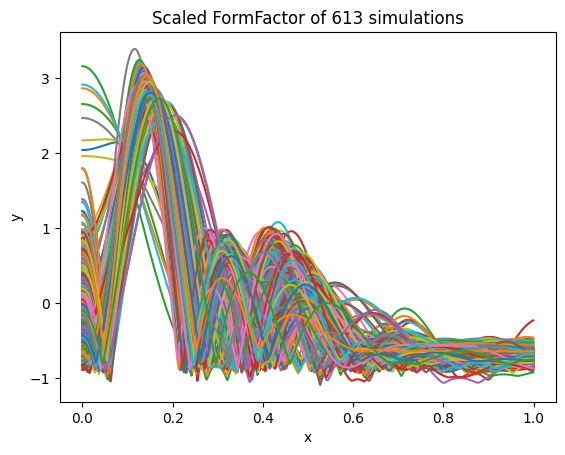

In [8]:
for i in FF_df.columns:
    plt.plot(np.arange(0,1,0.001), FF_df[i])

plt.xlabel('x')
plt.ylabel('y')
plt.title('Scaled FormFactor of 613 simulations')
plt.show()

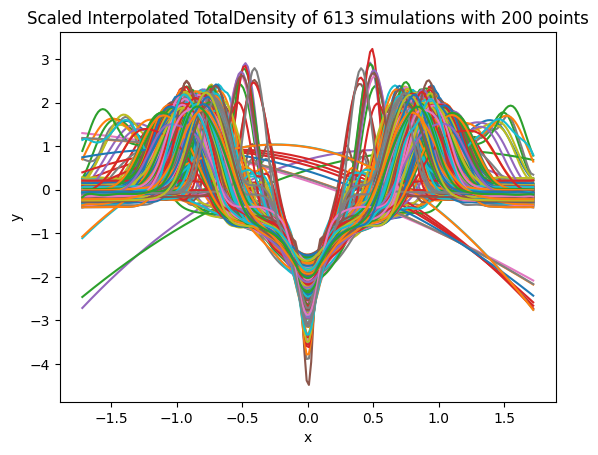

In [9]:
for index in TD_x_df.columns:
    plt.plot(TD_x_df[index],TD_y_df[index])
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scaled Interpolated TotalDensity of 613 simulations with 200 points')
plt.show()

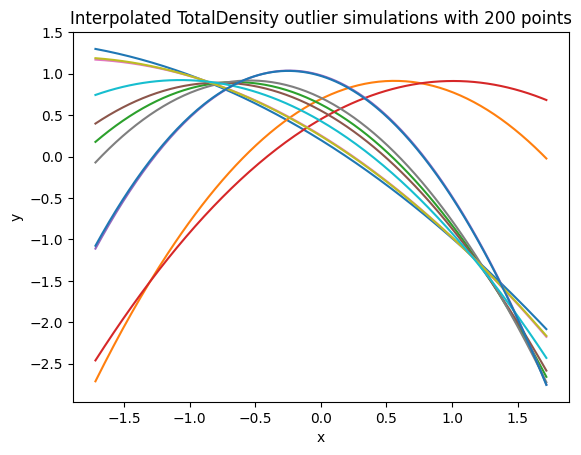

In [5]:
column_indexes = []
index = 0
for value in TD_y_df.iloc[99]:
    if value > -1:
        column_indexes.append(index)
    index = index + 1
    
for index in column_indexes:
    plt.plot(TD_x_df[index],TD_y_df[index])
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interpolated TotalDensity outlier simulations with 200 points')
plt.show()

In [6]:
FF_df = FF_df.drop(column_indexes, axis=1)
TD_x_df = TD_x_df.drop(column_indexes, axis=1)
TD_y_df = TD_y_df.drop(column_indexes, axis=1)

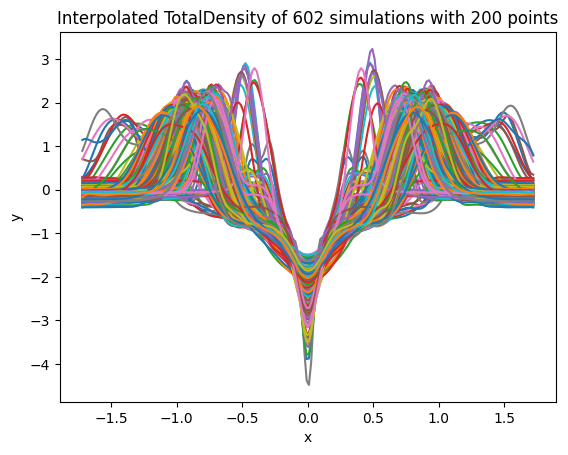

In [12]:
for index in TD_x_df.columns:
    plt.plot(TD_x_df[index],TD_y_df[index])
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interpolated TotalDensity of 602 simulations with 200 points')
plt.show()

In [13]:
FF_df

0         1         2         3         4         5         6    \
0    0.980720 -0.444256  0.186761 -0.047851 -0.354703 -0.584007 -0.183981   
1    0.980030 -0.444704  0.186284 -0.048252 -0.355220 -0.584411 -0.183635   
2    0.977961 -0.446046  0.184852 -0.049453 -0.356769 -0.585624 -0.182598   
3    0.974512 -0.448282  0.182466 -0.051454 -0.359351 -0.587644 -0.180870   
4    0.969687 -0.451412  0.179127 -0.054255 -0.362964 -0.590472 -0.178453   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.637919 -0.763000 -0.775248 -0.745377 -0.664294 -0.757084 -0.752626   
996 -0.637355 -0.762537 -0.774302 -0.744959 -0.665308 -0.758153 -0.751415   
997 -0.636854 -0.762078 -0.773360 -0.744537 -0.666345 -0.759220 -0.750233   
998 -0.636415 -0.761626 -0.772425 -0.744112 -0.667403 -0.760285 -0.749080   
999 -0.636038 -0.761180 -0.771495 -0.743684 -0.668483 -0.761346 -0.747956   

          7         8         9    ...       603       604       605  \
0   -0.309006 -0.349255  0.267737  ... -0.513892 -0.299718 -0.477219   
1   -0.309460 -0.349860  0.267305  ... -0.514353 -0.299953 -0.477644   
2   -0.310820 -0.351675  0.266009  ... -0.515734 -0.300657 -0.478919   
3   -0.313086 -0.354698  0.263851  ... -0.518037 -0.301829 -0.481043   
4   -0.316257 -0.358928  0.260830  ... -0.521258 -0.303470 -0.484016   
..        ...       ...       ...  ...       ...       ...       ...   
995 -0.656961 -0.656225 -0.777161  ... -0.857844 -0.764482 -0.705293   
996 -0.656542 -0.659345 -0.777468  ... -0.857907 -0.765611 -0.704952   
997 -0.656158 -0.662494 -0.777772  ... -0.857928 -0.766756 -0.704615   
998 -0.655810 -0.665672 -0.778070  ... -0.857907 -0.767919 -0.704282   
999 -0.655498 -0.668877 -0.778360  ... -0.857847 -0.769097 -0.703954   

          606       607       608       609       610       611       612  
0    0.087297 -0.142115  0.840006 -0.459976 -0.427894  0.672328 -0.105556  
1    0.086667 -0.142717  0.839384 -0.460461 -0.428323  0.671703 -0.105924  
2    0.084776 -0.144520  0.837520 -0.461915 -0.429612  0.669829 -0.107030  
3    0.081625 -0.147525  0.834413 -0.464338 -0.431758  0.666705 -0.108872  
4    0.077216 -0.151730  0.830066 -0.467729 -0.434762  0.662335 -0.111451  
..        ...       ...       ...       ...       ...       ...       ...  
995 -0.861659 -0.689449 -0.738946 -0.677948 -0.761120 -0.640692 -0.750145  
996 -0.862931 -0.690513 -0.738721 -0.677956 -0.760901 -0.640672 -0.749707  
997 -0.864157 -0.691557 -0.738505 -0.678050 -0.760640 -0.640653 -0.749303  
998 -0.865337 -0.692583 -0.738300 -0.678230 -0.760337 -0.640635 -0.748932  
999 -0.866470 -0.693590 -0.738105 -0.678494 -0.759994 -0.640617 -0.748596  

[1000 rows x 602 columns]

In [14]:
TD_x_df

0         1         2         3         4         5         6    \
0   -1.719098 -1.719098 -1.719098 -1.719098 -1.719098 -1.719098 -1.719098   
1   -1.701821 -1.701821 -1.701821 -1.701821 -1.701821 -1.701821 -1.701821   
2   -1.684543 -1.684543 -1.684543 -1.684543 -1.684543 -1.684543 -1.684543   
3   -1.667266 -1.667266 -1.667266 -1.667266 -1.667266 -1.667266 -1.667266   
4   -1.649989 -1.649989 -1.649989 -1.649989 -1.649989 -1.649989 -1.649989   
..        ...       ...       ...       ...       ...       ...       ...   
195  1.649989  1.649989  1.649989  1.649989  1.649989  1.649989  1.649989   
196  1.667266  1.667266  1.667266  1.667266  1.667266  1.667266  1.667266   
197  1.684543  1.684543  1.684543  1.684543  1.684543  1.684543  1.684543   
198  1.701821  1.701821  1.701821  1.701821  1.701821  1.701821  1.701821   
199  1.719098  1.719098  1.719098  1.719098  1.719098  1.719098  1.719098   

          7         8         9    ...       603       604       605  \
0   -1.719098 -1.719098 -1.719098  ... -1.719098 -1.719098 -1.719098   
1   -1.701821 -1.701821 -1.701821  ... -1.701821 -1.701821 -1.701821   
2   -1.684543 -1.684543 -1.684543  ... -1.684543 -1.684543 -1.684543   
3   -1.667266 -1.667266 -1.667266  ... -1.667266 -1.667266 -1.667266   
4   -1.649989 -1.649989 -1.649989  ... -1.649989 -1.649989 -1.649989   
..        ...       ...       ...  ...       ...       ...       ...   
195  1.649989  1.649989  1.649989  ...  1.649989  1.649989  1.649989   
196  1.667266  1.667266  1.667266  ...  1.667266  1.667266  1.667266   
197  1.684543  1.684543  1.684543  ...  1.684543  1.684543  1.684543   
198  1.701821  1.701821  1.701821  ...  1.701821  1.701821  1.701821   
199  1.719098  1.719098  1.719098  ...  1.719098  1.719098  1.719098   

          606       607       608       609       610       611       612  
0   -1.719098 -1.719098 -1.719098 -1.719098 -1.719098 -1.719098 -1.719098  
1   -1.701821 -1.701821 -1.701821 -1.701821 -1.701821 -1.701821 -1.701821  
2   -1.684543 -1.684543 -1.684543 -1.684543 -1.684543 -1.684543 -1.684543  
3   -1.667266 -1.667266 -1.667266 -1.667266 -1.667266 -1.667266 -1.667266  
4   -1.649989 -1.649989 -1.649989 -1.649989 -1.649989 -1.649989 -1.649989  
..        ...       ...       ...       ...       ...       ...       ...  
195  1.649989  1.649989  1.649989  1.649989  1.649989  1.649989  1.649989  
196  1.667266  1.667266  1.667266  1.667266  1.667266  1.667266  1.667266  
197  1.684543  1.684543  1.684543  1.684543  1.684543  1.684543  1.684543  
198  1.701821  1.701821  1.701821  1.701821  1.701821  1.701821  1.701821  
199  1.719098  1.719098  1.719098  1.719098  1.719098  1.719098  1.719098  

[200 rows x 602 columns]

In [15]:
TD_y_df

0         1         2         3         4         5         6    \
0   -0.292967 -0.043943 -0.158113 -0.101767 -0.074313 -0.015691  0.130820   
1   -0.287719 -0.048955 -0.158903 -0.108930 -0.065830 -0.027563  0.116175   
2   -0.285331 -0.054403 -0.159960 -0.112849 -0.062805 -0.033899  0.110771   
3   -0.284011 -0.057850 -0.160734 -0.114323 -0.062832 -0.036013  0.111254   
4   -0.283050 -0.058699 -0.161087 -0.114178 -0.064223 -0.035278  0.114579   
..        ...       ...       ...       ...       ...       ...       ...   
195 -0.284641 -0.058231 -0.159933 -0.114170 -0.065815 -0.040228  0.110020   
196 -0.285351 -0.056702 -0.158876 -0.114536 -0.064869 -0.039316  0.107380   
197 -0.286225 -0.055992 -0.158280 -0.115670 -0.063731 -0.035067  0.103959   
198 -0.288039 -0.057726 -0.159393 -0.117792 -0.063152 -0.025993  0.099929   
199 -0.292285 -0.064301 -0.164136 -0.121192 -0.064547 -0.010529  0.095253   

          7         8         9    ...       603       604       605  \
0   -0.081422 -0.077652 -0.176547  ... -0.055277 -0.100642 -0.038685   
1   -0.081356 -0.076761 -0.174650  ... -0.045650 -0.097157 -0.037322   
2   -0.082830 -0.074020 -0.173992  ... -0.044475 -0.097230 -0.037047   
3   -0.084084 -0.071692 -0.173963  ... -0.047638 -0.100022 -0.037256   
4   -0.084358 -0.070750 -0.174172  ... -0.051569 -0.104700 -0.037584   
..        ...       ...       ...  ...       ...       ...       ...   
195 -0.085534 -0.071605 -0.173548  ... -0.054341 -0.099677 -0.037964   
196 -0.088656 -0.073382 -0.173128  ... -0.051663 -0.095382 -0.038246   
197 -0.089890 -0.076052 -0.173129  ... -0.051372 -0.093211 -0.038337   
198 -0.087382 -0.079193 -0.173866  ... -0.056617 -0.094425 -0.037948   
199 -0.079401 -0.081836 -0.175784  ... -0.072725 -0.100615 -0.036756   

          606       607       608       609       610       611       612  
0   -0.145616 -0.091428 -0.245502 -0.061689 -0.065606 -0.220929 -0.171157  
1   -0.147582 -0.080542 -0.245715 -0.050817 -0.060005 -0.218079 -0.128594  
2   -0.148528 -0.080141 -0.246071 -0.053721 -0.057062 -0.216923 -0.104758  
3   -0.147606 -0.082219 -0.246198 -0.060734 -0.055632 -0.216739 -0.095096  
4   -0.145384 -0.083096 -0.246001 -0.066050 -0.055196 -0.216993 -0.095194  
..        ...       ...       ...       ...       ...       ...       ...  
195 -0.144443 -0.080849 -0.246660 -0.048337 -0.057925 -0.217384 -0.111441  
196 -0.143589 -0.076135 -0.246312 -0.048564 -0.064769 -0.216985 -0.107901  
197 -0.142992 -0.073838 -0.246020 -0.052194 -0.069580 -0.216915 -0.105345  
198 -0.144643 -0.080083 -0.246297 -0.061096 -0.068880 -0.217690 -0.105507  
199 -0.152251 -0.103521 -0.248100 -0.078233 -0.059392 -0.220034 -0.110609  

[200 rows x 602 columns]

In [7]:
names = []
for i in TD_x_df.columns:
    names.append(str(i) + 'x')
    names.append(str(i) + 'y')

TD_df = pd.DataFrame(index=range(200),columns=[names])

for i in TD_x_df.columns:
    x_value = []
    y_value = []
    for value in TD_x_df[i]:
        x_value.append(value)
    for value in TD_y_df[i]:
        y_value.append(value)
    
    TD_df[str(i) + 'x'] = x_value
    TD_df[str(i) + 'y'] = y_value
    
TD_df

0x        0y        1x        1y        2x        2y        3x  \
0   -1.719098 -0.292967 -1.719098 -0.043943 -1.719098 -0.158113 -1.719098   
1   -1.701821 -0.287719 -1.701821 -0.048955 -1.701821 -0.158903 -1.701821   
2   -1.684543 -0.285331 -1.684543 -0.054403 -1.684543 -0.159960 -1.684543   
3   -1.667266 -0.284011 -1.667266 -0.057850 -1.667266 -0.160734 -1.667266   
4   -1.649989 -0.283050 -1.649989 -0.058699 -1.649989 -0.161087 -1.649989   
..        ...       ...       ...       ...       ...       ...       ...   
195  1.649989 -0.284641  1.649989 -0.058231  1.649989 -0.159933  1.649989   
196  1.667266 -0.285351  1.667266 -0.056702  1.667266 -0.158876  1.667266   
197  1.684543 -0.286225  1.684543 -0.055992  1.684543 -0.158280  1.684543   
198  1.701821 -0.288039  1.701821 -0.057726  1.701821 -0.159393  1.701821   
199  1.719098 -0.292285  1.719098 -0.064301  1.719098 -0.164136  1.719098   

           3y        4x        4y  ...      608x      608y      609x  \
0   -0.101767 -1.719098 -0.074313  ... -1.719098 -0.245502 -1.719098   
1   -0.108930 -1.701821 -0.065830  ... -1.701821 -0.245715 -1.701821   
2   -0.112849 -1.684543 -0.062805  ... -1.684543 -0.246071 -1.684543   
3   -0.114323 -1.667266 -0.062832  ... -1.667266 -0.246198 -1.667266   
4   -0.114178 -1.649989 -0.064223  ... -1.649989 -0.246001 -1.649989   
..        ...       ...       ...  ...       ...       ...       ...   
195 -0.114170  1.649989 -0.065815  ...  1.649989 -0.246660  1.649989   
196 -0.114536  1.667266 -0.064869  ...  1.667266 -0.246312  1.667266   
197 -0.115670  1.684543 -0.063731  ...  1.684543 -0.246020  1.684543   
198 -0.117792  1.701821 -0.063152  ...  1.701821 -0.246297  1.701821   
199 -0.121192  1.719098 -0.064547  ...  1.719098 -0.248100  1.719098   

         609y      610x      610y      611x      611y      612x      612y  
0   -0.061689 -1.719098 -0.065606 -1.719098 -0.220929 -1.719098 -0.171157  
1   -0.050817 -1.701821 -0.060005 -1.701821 -0.218079 -1.701821 -0.128594  
2   -0.053721 -1.684543 -0.057062 -1.684543 -0.216923 -1.684543 -0.104758  
3   -0.060734 -1.667266 -0.055632 -1.667266 -0.216739 -1.667266 -0.095096  
4   -0.066050 -1.649989 -0.055196 -1.649989 -0.216993 -1.649989 -0.095194  
..        ...       ...       ...       ...       ...       ...       ...  
195 -0.048337  1.649989 -0.057925  1.649989 -0.217384  1.649989 -0.111441  
196 -0.048564  1.667266 -0.064769  1.667266 -0.216985  1.667266 -0.107901  
197 -0.052194  1.684543 -0.069580  1.684543 -0.216915  1.684543 -0.105345  
198 -0.061096  1.701821 -0.068880  1.701821 -0.217690  1.701821 -0.105507  
199 -0.078233  1.719098 -0.059392  1.719098 -0.220034  1.719098 -0.110609  

[200 rows x 1204 columns]

In [8]:
input_data = FF_df.iloc[: , :-2]
output_data = TD_df.iloc[: , :-4]

In [18]:
input_data

0         1         2         3         4         5         6    \
0    0.980720 -0.444256  0.186761 -0.047851 -0.354703 -0.584007 -0.183981   
1    0.980030 -0.444704  0.186284 -0.048252 -0.355220 -0.584411 -0.183635   
2    0.977961 -0.446046  0.184852 -0.049453 -0.356769 -0.585624 -0.182598   
3    0.974512 -0.448282  0.182466 -0.051454 -0.359351 -0.587644 -0.180870   
4    0.969687 -0.451412  0.179127 -0.054255 -0.362964 -0.590472 -0.178453   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.637919 -0.763000 -0.775248 -0.745377 -0.664294 -0.757084 -0.752626   
996 -0.637355 -0.762537 -0.774302 -0.744959 -0.665308 -0.758153 -0.751415   
997 -0.636854 -0.762078 -0.773360 -0.744537 -0.666345 -0.759220 -0.750233   
998 -0.636415 -0.761626 -0.772425 -0.744112 -0.667403 -0.760285 -0.749080   
999 -0.636038 -0.761180 -0.771495 -0.743684 -0.668483 -0.761346 -0.747956   

          7         8         9    ...       601       602       603  \
0   -0.309006 -0.349255  0.267737  ... -0.670520 -0.250014 -0.513892   
1   -0.309460 -0.349860  0.267305  ... -0.670950 -0.250566 -0.514353   
2   -0.310820 -0.351675  0.266009  ... -0.672240 -0.252221 -0.515734   
3   -0.313086 -0.354698  0.263851  ... -0.674390 -0.254978 -0.518037   
4   -0.316257 -0.358928  0.260830  ... -0.677398 -0.258837 -0.521258   
..        ...       ...       ...  ...       ...       ...       ...   
995 -0.656961 -0.656225 -0.777161  ... -0.743381 -0.669381 -0.857844   
996 -0.656542 -0.659345 -0.777468  ... -0.743575 -0.669735 -0.857907   
997 -0.656158 -0.662494 -0.777772  ... -0.743771 -0.670089 -0.857928   
998 -0.655810 -0.665672 -0.778070  ... -0.743970 -0.670442 -0.857907   
999 -0.655498 -0.668877 -0.778360  ... -0.744172 -0.670794 -0.857847   

          604       605       606       607       608       609       610  
0   -0.299718 -0.477219  0.087297 -0.142115  0.840006 -0.459976 -0.427894  
1   -0.299953 -0.477644  0.086667 -0.142717  0.839384 -0.460461 -0.428323  
2   -0.300657 -0.478919  0.084776 -0.144520  0.837520 -0.461915 -0.429612  
3   -0.301829 -0.481043  0.081625 -0.147525  0.834413 -0.464338 -0.431758  
4   -0.303470 -0.484016  0.077216 -0.151730  0.830066 -0.467729 -0.434762  
..        ...       ...       ...       ...       ...       ...       ...  
995 -0.764482 -0.705293 -0.861659 -0.689449 -0.738946 -0.677948 -0.761120  
996 -0.765611 -0.704952 -0.862931 -0.690513 -0.738721 -0.677956 -0.760901  
997 -0.766756 -0.704615 -0.864157 -0.691557 -0.738505 -0.678050 -0.760640  
998 -0.767919 -0.704282 -0.865337 -0.692583 -0.738300 -0.678230 -0.760337  
999 -0.769097 -0.703954 -0.866470 -0.693590 -0.738105 -0.678494 -0.759994  

[1000 rows x 600 columns]

In [19]:
output_data

0x        0y        1x        1y        2x        2y        3x  \
0   -1.719098 -0.292967 -1.719098 -0.043943 -1.719098 -0.158113 -1.719098   
1   -1.701821 -0.287719 -1.701821 -0.048955 -1.701821 -0.158903 -1.701821   
2   -1.684543 -0.285331 -1.684543 -0.054403 -1.684543 -0.159960 -1.684543   
3   -1.667266 -0.284011 -1.667266 -0.057850 -1.667266 -0.160734 -1.667266   
4   -1.649989 -0.283050 -1.649989 -0.058699 -1.649989 -0.161087 -1.649989   
..        ...       ...       ...       ...       ...       ...       ...   
195  1.649989 -0.284641  1.649989 -0.058231  1.649989 -0.159933  1.649989   
196  1.667266 -0.285351  1.667266 -0.056702  1.667266 -0.158876  1.667266   
197  1.684543 -0.286225  1.684543 -0.055992  1.684543 -0.158280  1.684543   
198  1.701821 -0.288039  1.701821 -0.057726  1.701821 -0.159393  1.701821   
199  1.719098 -0.292285  1.719098 -0.064301  1.719098 -0.164136  1.719098   

           3y        4x        4y  ...      606x      606y      607x  \
0   -0.101767 -1.719098 -0.074313  ... -1.719098 -0.145616 -1.719098   
1   -0.108930 -1.701821 -0.065830  ... -1.701821 -0.147582 -1.701821   
2   -0.112849 -1.684543 -0.062805  ... -1.684543 -0.148528 -1.684543   
3   -0.114323 -1.667266 -0.062832  ... -1.667266 -0.147606 -1.667266   
4   -0.114178 -1.649989 -0.064223  ... -1.649989 -0.145384 -1.649989   
..        ...       ...       ...  ...       ...       ...       ...   
195 -0.114170  1.649989 -0.065815  ...  1.649989 -0.144443  1.649989   
196 -0.114536  1.667266 -0.064869  ...  1.667266 -0.143589  1.667266   
197 -0.115670  1.684543 -0.063731  ...  1.684543 -0.142992  1.684543   
198 -0.117792  1.701821 -0.063152  ...  1.701821 -0.144643  1.701821   
199 -0.121192  1.719098 -0.064547  ...  1.719098 -0.152251  1.719098   

         607y      608x      608y      609x      609y      610x      610y  
0   -0.091428 -1.719098 -0.245502 -1.719098 -0.061689 -1.719098 -0.065606  
1   -0.080542 -1.701821 -0.245715 -1.701821 -0.050817 -1.701821 -0.060005  
2   -0.080141 -1.684543 -0.246071 -1.684543 -0.053721 -1.684543 -0.057062  
3   -0.082219 -1.667266 -0.246198 -1.667266 -0.060734 -1.667266 -0.055632  
4   -0.083096 -1.649989 -0.246001 -1.649989 -0.066050 -1.649989 -0.055196  
..        ...       ...       ...       ...       ...       ...       ...  
195 -0.080849  1.649989 -0.246660  1.649989 -0.048337  1.649989 -0.057925  
196 -0.076135  1.667266 -0.246312  1.667266 -0.048564  1.667266 -0.064769  
197 -0.073838  1.684543 -0.246020  1.684543 -0.052194  1.684543 -0.069580  
198 -0.080083  1.701821 -0.246297  1.701821 -0.061096  1.701821 -0.068880  
199 -0.103521  1.719098 -0.248100  1.719098 -0.078233  1.719098 -0.059392  

[200 rows x 1200 columns]

In [9]:
column_index = []
for i in input_data.columns:
    column_index.append(i)

random.seed(42)
train = random.sample(column_index,488)
test = []
for number in column_index:
    if not number in train:
        test.append(number)

print(train)
print(test)

[119, 27, 286, 255, 233, 147, 109, 569, 94, 442, 34, 32, 100, 228, 243, 527, 29, 585, 208, 603, 439, 230, 469, 289, 6, 168, 601, 356, 587, 164, 225, 351, 604, 99, 398, 104, 375, 360, 275, 47, 480, 560, 132, 396, 84, 306, 378, 201, 74, 49, 238, 301, 85, 596, 108, 576, 582, 474, 381, 171, 388, 371, 219, 278, 76, 180, 607, 172, 483, 397, 281, 229, 339, 60, 239, 600, 330, 419, 279, 70, 221, 329, 222, 521, 414, 479, 151, 276, 605, 131, 390, 292, 280, 139, 391, 305, 224, 588, 304, 209, 190, 117, 73, 265, 257, 561, 395, 26, 450, 59, 81, 328, 558, 525, 583, 529, 312, 534, 202, 200, 493, 244, 572, 133, 288, 501, 5, 495, 377, 61, 357, 463, 531, 393, 141, 402, 335, 179, 536, 155, 227, 566, 237, 1, 481, 458, 376, 516, 261, 399, 96, 264, 57, 455, 327, 157, 440, 334, 464, 318, 106, 499, 196, 460, 86, 539, 407, 522, 0, 313, 170, 543, 9, 471, 509, 422, 162, 127, 31, 128, 295, 42, 46, 382, 253, 37, 555, 277, 401, 67, 68, 344, 248, 608, 88, 140, 487, 317, 494, 113, 444, 503, 552, 361, 107, 373, 581, 510

In [10]:
train_input_values = []
for number in train:
    train_input_values.append(input_data[number])
    
train_output_values = []
for number in train:
    list_1 = output_data[str(number) + 'x']
    list_2 = output_data[str(number) + 'y']
    train_output_values.append(np.concatenate((list_1,list_2)))

test_input_values = []
for number in test:
    test_input_values.append(input_data[number])
    
test_output_values = []
for number in test:
    list_1 = output_data[str(number) + 'x']
    list_2 = output_data[str(number) + 'y']
    test_output_values.append(np.concatenate((list_1,list_2)))
    
train_input_values = np.array(train_input_values).astype(np.float32)
train_output_values = np.array(train_output_values).astype(np.float32)
test_input_values = np.array(test_input_values).astype(np.float32)
test_output_values = np.array(test_output_values).astype(np.float32)

print(train_input_values.shape)
print(train_output_values.shape)
print(test_input_values.shape)
print(test_output_values.shape)

(488, 1000)
(488, 400, 1)
(112, 1000)
(112, 400, 1)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_4 (Dense)             (None, 2000)              2002000   
                                                                 
 dropout_3 (Dropout)         (None, 2000)              0         
                                                                 
 dense_5 (Dense)             (None, 1000)              2001000   
                                                                 
 dropout_4 (Dropout)         (None, 1000)              0         
                                                                 
 dense_6 (Dense)             (None, 1000)              1001000   
                                                                 
 dropout_5 (Dropout)         (None, 1000)              0   

7/7 [==============================] - 1s 92ms/step - loss: 0.1211 - val_loss: 0.1236
Epoch 69/1500
7/7 [==============================] - 1s 91ms/step - loss: 0.1209 - val_loss: 0.1717
Epoch 70/1500
7/7 [==============================] - 1s 96ms/step - loss: 0.1325 - val_loss: 0.1421
Epoch 71/1500
7/7 [==============================] - 1s 226ms/step - loss: 0.1192 - val_loss: 0.1377
Epoch 72/1500
7/7 [==============================] - 1s 96ms/step - loss: 0.1229 - val_loss: 0.1217
Epoch 73/1500
7/7 [==============================] - 1s 92ms/step - loss: 0.1169 - val_loss: 0.1288
Epoch 74/1500
7/7 [==============================] - 1s 94ms/step - loss: 0.1123 - val_loss: 0.1380
Epoch 75/1500
7/7 [==============================] - 1s 96ms/step - loss: 0.1155 - val_loss: 0.1344
Epoch 76/1500
7/7 [==============================] - 1s 94ms/step - loss: 0.1132 - val_loss: 0.1258
Epoch 77/1500
7/7 [==============================] - 1s 91ms/step - loss: 0.1110 - val_loss: 0.1324
Epoch 78/1500

7/7 [==============================] - 1s 92ms/step - loss: 0.0906 - val_loss: 0.1046
Epoch 231/1500
7/7 [==============================] - 1s 229ms/step - loss: 0.0910 - val_loss: 0.1043
Epoch 232/1500
7/7 [==============================] - 1s 93ms/step - loss: 0.0912 - val_loss: 0.1029
Epoch 233/1500
7/7 [==============================] - 1s 92ms/step - loss: 0.0900 - val_loss: 0.1068
Epoch 234/1500
7/7 [==============================] - 1s 92ms/step - loss: 0.0888 - val_loss: 0.1079
Epoch 235/1500
7/7 [==============================] - 1s 98ms/step - loss: 0.0885 - val_loss: 0.1051
Epoch 236/1500
7/7 [==============================] - 1s 92ms/step - loss: 0.0905 - val_loss: 0.1046
Epoch 237/1500
7/7 [==============================] - 1s 137ms/step - loss: 0.0877 - val_loss: 0.1062
Epoch 238/1500
7/7 [==============================] - 1s 94ms/step - loss: 0.0881 - val_loss: 0.1058
Epoch 239/1500
7/7 [==============================] - 1s 91ms/step - loss: 0.0887 - val_loss: 0.1081
Epo

Epoch 311/1500
7/7 [==============================] - 1s 229ms/step - loss: 0.0827 - val_loss: 0.1037
Epoch 312/1500
7/7 [==============================] - 1s 97ms/step - loss: 0.0842 - val_loss: 0.1073
Epoch 313/1500
7/7 [==============================] - 1s 95ms/step - loss: 0.0838 - val_loss: 0.1060
Epoch 314/1500
7/7 [==============================] - 1s 91ms/step - loss: 0.0844 - val_loss: 0.1071
Epoch 315/1500
7/7 [==============================] - 1s 93ms/step - loss: 0.0858 - val_loss: 0.1035
Epoch 316/1500
7/7 [==============================] - 1s 96ms/step - loss: 0.0842 - val_loss: 0.1021
Epoch 317/1500
7/7 [==============================] - 1s 93ms/step - loss: 0.0860 - val_loss: 0.1099
Epoch 318/1500
7/7 [==============================] - 1s 93ms/step - loss: 0.0849 - val_loss: 0.1012
Epoch 319/1500
7/7 [==============================] - 1s 99ms/step - loss: 0.0842 - val_loss: 0.1011
Epoch 320/1500
7/7 [==============================] - 1s 95ms/step - loss: 0.0855 - val_lo

Epoch 392/1500
7/7 [==============================] - 1s 96ms/step - loss: 0.0809 - val_loss: 0.1025
Epoch 393/1500
7/7 [==============================] - 1s 91ms/step - loss: 0.0808 - val_loss: 0.1012
Epoch 394/1500
7/7 [==============================] - 1s 97ms/step - loss: 0.0840 - val_loss: 0.1035
Epoch 395/1500
7/7 [==============================] - 1s 91ms/step - loss: 0.0862 - val_loss: 0.1128
Epoch 396/1500
7/7 [==============================] - 1s 92ms/step - loss: 0.0876 - val_loss: 0.1079
Epoch 397/1500
7/7 [==============================] - 1s 95ms/step - loss: 0.0845 - val_loss: 0.1051
Epoch 398/1500
7/7 [==============================] - 1s 92ms/step - loss: 0.0821 - val_loss: 0.1007
Epoch 399/1500
7/7 [==============================] - 1s 94ms/step - loss: 0.0784 - val_loss: 0.1011
Epoch 400/1500
7/7 [==============================] - 1s 89ms/step - loss: 0.0778 - val_loss: 0.1042
Epoch 401/1500
7/7 [==============================] - 1s 229ms/step - loss: 0.0826 - val_lo

Epoch 473/1500
7/7 [==============================] - 1s 94ms/step - loss: 0.0802 - val_loss: 0.1026
Epoch 474/1500
7/7 [==============================] - 1s 98ms/step - loss: 0.0831 - val_loss: 0.1024
Epoch 475/1500
7/7 [==============================] - 1s 93ms/step - loss: 0.0909 - val_loss: 0.1048
Epoch 476/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0858 - val_loss: 0.1123
Epoch 477/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0810 - val_loss: 0.1086
Epoch 478/1500
7/7 [==============================] - 1s 107ms/step - loss: 0.0843 - val_loss: 0.1039
Epoch 479/1500
7/7 [==============================] - 3s 472ms/step - loss: 0.0787 - val_loss: 0.1032
Epoch 480/1500
7/7 [==============================] - 2s 304ms/step - loss: 0.0787 - val_loss: 0.1057
Epoch 481/1500
7/7 [==============================] - 2s 273ms/step - loss: 0.0818 - val_loss: 0.1027
Epoch 482/1500
7/7 [==============================] - 1s 96ms/step - loss: 0.0790 - v

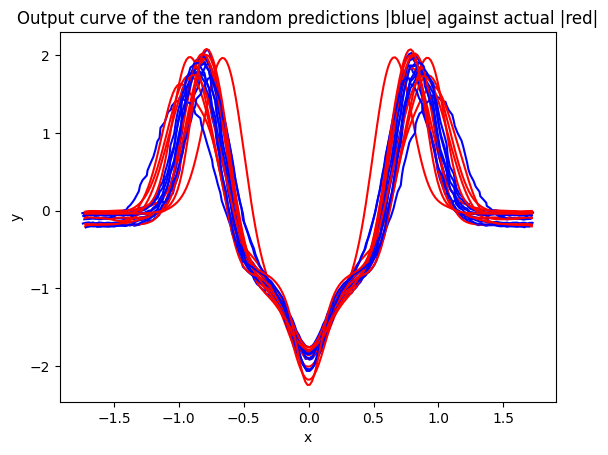

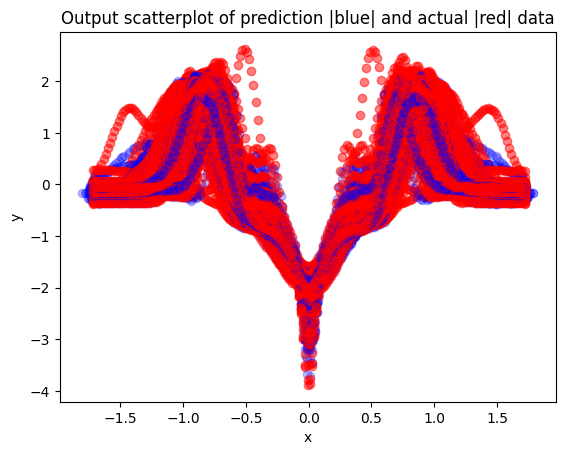

In [24]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_3_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=64, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

4/4 [==============================] - 0s 7ms/step


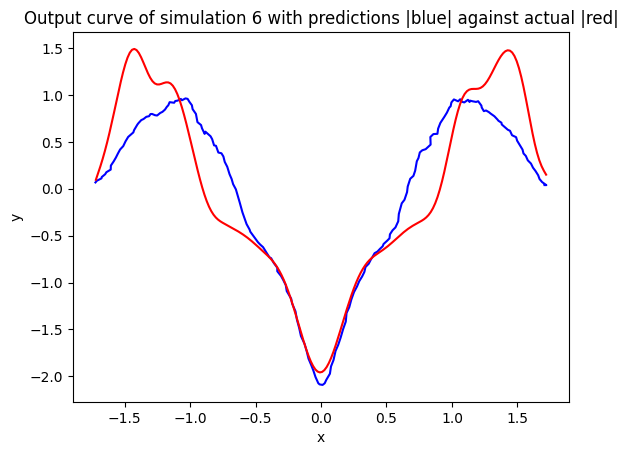

In [31]:
number = 6 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 11ms/step


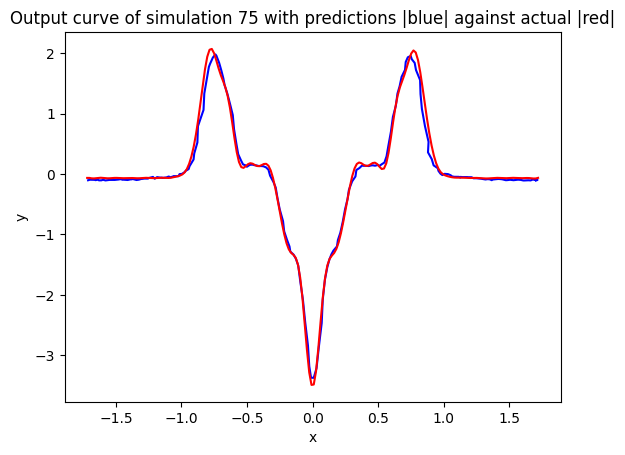

In [32]:
number = 75 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 8ms/step


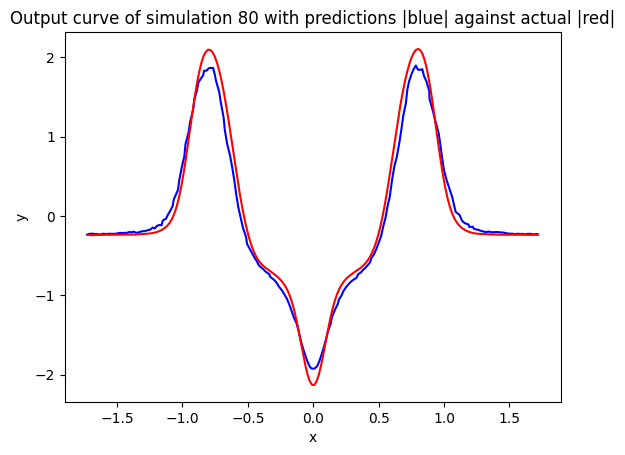

In [33]:
number = 80 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_8 (Dense)             (None, 2000)              2002000   
                                                                 
 dropout_6 (Dropout)         (None, 2000)              0         
                                                                 
 dense_9 (Dense)             (None, 1000)              2001000   
                                                                 
 dropout_7 (Dropout)         (None, 1000)              0         
                                                                 
 dense_10 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_8 (Dropout)         (None, 2000)              0   

Epoch 148/1500
7/7 [==============================] - 1s 114ms/step - loss: 0.0952 - val_loss: 0.1102
Epoch 149/1500
7/7 [==============================] - 1s 115ms/step - loss: 0.0906 - val_loss: 0.1049
Epoch 150/1500
7/7 [==============================] - 1s 114ms/step - loss: 0.0887 - val_loss: 0.1049
Epoch 151/1500
7/7 [==============================] - 2s 279ms/step - loss: 0.0900 - val_loss: 0.1118
Epoch 152/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0916 - val_loss: 0.1132
Epoch 153/1500
7/7 [==============================] - 1s 112ms/step - loss: 0.0944 - val_loss: 0.1086
Epoch 154/1500
7/7 [==============================] - 1s 115ms/step - loss: 0.0944 - val_loss: 0.1174
Epoch 155/1500
7/7 [==============================] - 1s 112ms/step - loss: 0.0922 - val_loss: 0.1133
Epoch 156/1500
7/7 [==============================] - 1s 114ms/step - loss: 0.0928 - val_loss: 0.1081
Epoch 157/1500
7/7 [==============================] - 1s 111ms/step - loss: 0.0891

7/7 [==============================] - 1s 112ms/step - loss: 0.0874 - val_loss: 0.1065
Epoch 309/1500
7/7 [==============================] - 1s 108ms/step - loss: 0.0871 - val_loss: 0.1061
Epoch 310/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0861 - val_loss: 0.1036
Epoch 311/1500
7/7 [==============================] - 2s 280ms/step - loss: 0.0840 - val_loss: 0.1026
Epoch 312/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0824 - val_loss: 0.1017
Epoch 313/1500
7/7 [==============================] - 1s 110ms/step - loss: 0.0847 - val_loss: 0.1029
Epoch 314/1500
7/7 [==============================] - 1s 113ms/step - loss: 0.0799 - val_loss: 0.1035
Epoch 315/1500
7/7 [==============================] - 1s 112ms/step - loss: 0.0790 - val_loss: 0.0956
Epoch 316/1500
7/7 [==============================] - 1s 111ms/step - loss: 0.0892 - val_loss: 0.1075
Epoch 317/1500
7/7 [==============================] - 1s 112ms/step - loss: 0.0885 - val_loss: 0.

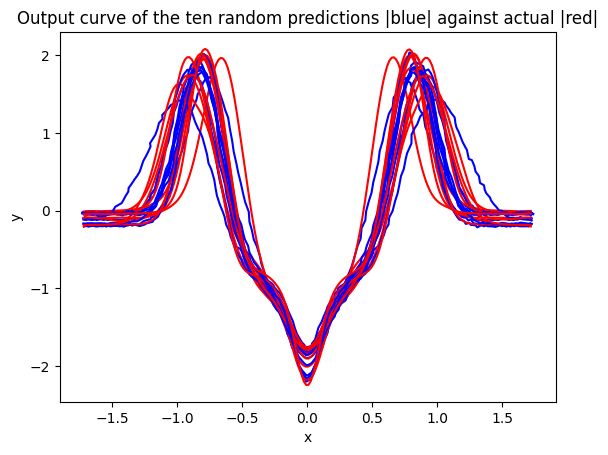

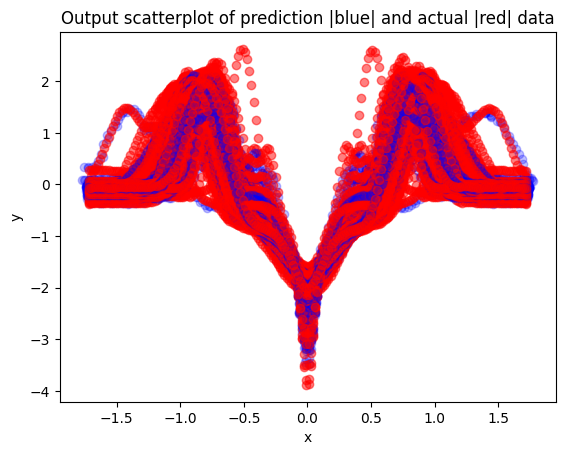

In [34]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_3_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=64, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

4/4 [==============================] - 0s 11ms/step


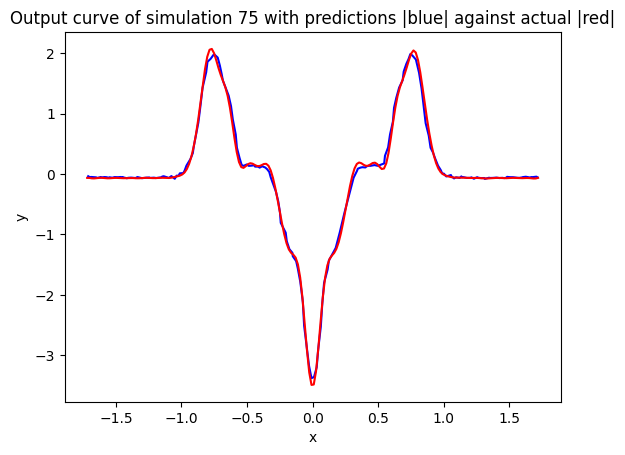

In [35]:
number = 75 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 10ms/step


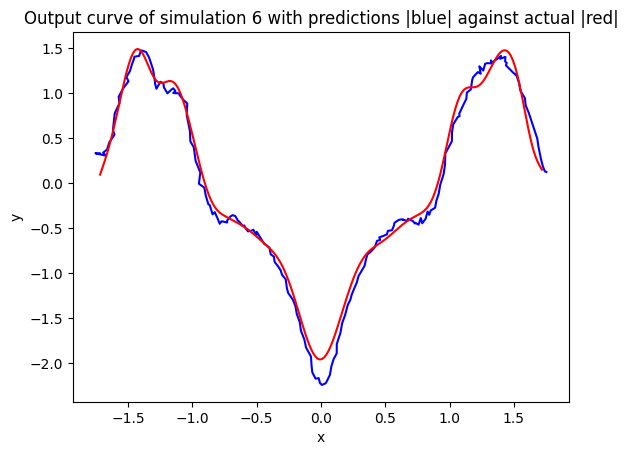

In [36]:
number = 6 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 10ms/step


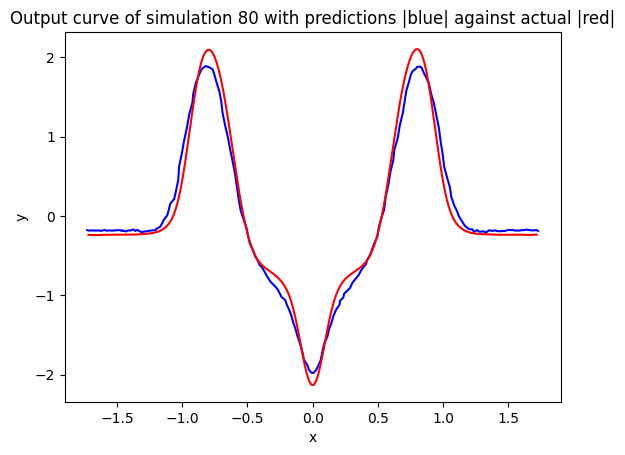

In [37]:
number = 80 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_12 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_9 (Dropout)         (None, 2000)              0         
                                                                 
 dense_13 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_10 (Dropout)        (None, 1000)              0         
                                                                 
 dense_14 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_11 (Dropout)        (None, 2000)              0   

Epoch 148/1500
7/7 [==============================] - 1s 115ms/step - loss: 0.0930 - val_loss: 0.1122
Epoch 149/1500
7/7 [==============================] - 1s 115ms/step - loss: 0.0918 - val_loss: 0.1142
Epoch 150/1500
7/7 [==============================] - 1s 110ms/step - loss: 0.0923 - val_loss: 0.1092
Epoch 151/1500
7/7 [==============================] - 2s 287ms/step - loss: 0.0940 - val_loss: 0.1185
Epoch 152/1500
7/7 [==============================] - 1s 131ms/step - loss: 0.0974 - val_loss: 0.1178
Epoch 153/1500
7/7 [==============================] - 1s 117ms/step - loss: 0.0963 - val_loss: 0.1160
Epoch 154/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0933 - val_loss: 0.1137
Epoch 155/1500
7/7 [==============================] - 1s 112ms/step - loss: 0.0955 - val_loss: 0.1131
Epoch 156/1500
7/7 [==============================] - 1s 115ms/step - loss: 0.0962 - val_loss: 0.1109
Epoch 157/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0918

7/7 [==============================] - 1s 113ms/step - loss: 0.0832 - val_loss: 0.1008
Epoch 309/1500
7/7 [==============================] - 1s 111ms/step - loss: 0.0824 - val_loss: 0.1024
Epoch 310/1500
7/7 [==============================] - 1s 111ms/step - loss: 0.0836 - val_loss: 0.1036
Epoch 311/1500
7/7 [==============================] - 2s 276ms/step - loss: 0.0850 - val_loss: 0.1147
Epoch 312/1500
7/7 [==============================] - 1s 109ms/step - loss: 0.0855 - val_loss: 0.1091
Epoch 313/1500
7/7 [==============================] - 1s 108ms/step - loss: 0.0843 - val_loss: 0.1035
Epoch 314/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0870 - val_loss: 0.1084
Epoch 315/1500
7/7 [==============================] - 1s 109ms/step - loss: 0.0878 - val_loss: 0.1109
Epoch 316/1500
7/7 [==============================] - 1s 110ms/step - loss: 0.0863 - val_loss: 0.1065
Epoch 317/1500
7/7 [==============================] - 1s 106ms/step - loss: 0.0852 - val_loss: 0.

7/7 [==============================] - 1s 113ms/step - loss: 0.0844 - val_loss: 0.1082
Epoch 469/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0831 - val_loss: 0.1062
Epoch 470/1500
7/7 [==============================] - 1s 109ms/step - loss: 0.0833 - val_loss: 0.1105
Epoch 471/1500
7/7 [==============================] - 2s 283ms/step - loss: 0.0860 - val_loss: 0.1095
Epoch 472/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0855 - val_loss: 0.1123
Epoch 473/1500
7/7 [==============================] - 1s 115ms/step - loss: 0.0873 - val_loss: 0.1069
Epoch 474/1500
7/7 [==============================] - 1s 183ms/step - loss: 0.0824 - val_loss: 0.1035
Epoch 475/1500
7/7 [==============================] - 1s 199ms/step - loss: 0.0828 - val_loss: 0.1048
Epoch 476/1500
7/7 [==============================] - 1s 109ms/step - loss: 0.0829 - val_loss: 0.1062
Epoch 477/1500
7/7 [==============================] - 1s 112ms/step - loss: 0.0862 - val_loss: 0.

7/7 [==============================] - 1s 109ms/step - loss: 0.0807 - val_loss: 0.1018
Epoch 629/1500
7/7 [==============================] - 1s 112ms/step - loss: 0.0762 - val_loss: 0.0992
Epoch 630/1500
7/7 [==============================] - 1s 111ms/step - loss: 0.0752 - val_loss: 0.0992
Epoch 631/1500
7/7 [==============================] - 2s 280ms/step - loss: 0.0772 - val_loss: 0.1027
Epoch 632/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0764 - val_loss: 0.0994
Epoch 633/1500
7/7 [==============================] - 1s 113ms/step - loss: 0.0748 - val_loss: 0.1016
Epoch 634/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0751 - val_loss: 0.1000
Epoch 635/1500
7/7 [==============================] - 1s 111ms/step - loss: 0.0754 - val_loss: 0.1006
Epoch 636/1500
7/7 [==============================] - 1s 112ms/step - loss: 0.0780 - val_loss: 0.0998
Epoch 637/1500
7/7 [==============================] - 1s 110ms/step - loss: 0.0756 - val_loss: 0.

7/7 [==============================] - 1s 117ms/step - loss: 0.0785 - val_loss: 0.0994
Epoch 789/1500
7/7 [==============================] - 1s 112ms/step - loss: 0.0770 - val_loss: 0.1047
Epoch 790/1500
7/7 [==============================] - 1s 113ms/step - loss: 0.0746 - val_loss: 0.1034
Epoch 791/1500
7/7 [==============================] - 2s 282ms/step - loss: 0.0789 - val_loss: 0.1011
Epoch 792/1500
7/7 [==============================] - 1s 114ms/step - loss: 0.0762 - val_loss: 0.1001
Epoch 793/1500
7/7 [==============================] - 1s 115ms/step - loss: 0.0771 - val_loss: 0.1071
Epoch 794/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0832 - val_loss: 0.1000
Epoch 795/1500
7/7 [==============================] - 1s 157ms/step - loss: 0.0733 - val_loss: 0.0969
Epoch 796/1500
7/7 [==============================] - 2s 241ms/step - loss: 0.0752 - val_loss: 0.1000
Epoch 797/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0761 - val_loss: 0.

7/7 [==============================] - 1s 112ms/step - loss: 0.0679 - val_loss: 0.0978
Epoch 949/1500
7/7 [==============================] - 1s 115ms/step - loss: 0.0680 - val_loss: 0.0997
Epoch 950/1500
7/7 [==============================] - 1s 115ms/step - loss: 0.0702 - val_loss: 0.0973
Epoch 951/1500
7/7 [==============================] - 2s 282ms/step - loss: 0.0687 - val_loss: 0.1002
Epoch 952/1500
7/7 [==============================] - 1s 110ms/step - loss: 0.0620 - val_loss: 0.0980
Epoch 953/1500
7/7 [==============================] - 1s 114ms/step - loss: 0.0617 - val_loss: 0.0999
Epoch 954/1500
7/7 [==============================] - 1s 112ms/step - loss: 0.0684 - val_loss: 0.0993
Epoch 955/1500
7/7 [==============================] - 1s 112ms/step - loss: 0.0653 - val_loss: 0.0995
Epoch 956/1500
7/7 [==============================] - 1s 113ms/step - loss: 0.0676 - val_loss: 0.0995
Epoch 957/1500
7/7 [==============================] - 1s 114ms/step - loss: 0.0650 - val_loss: 0.

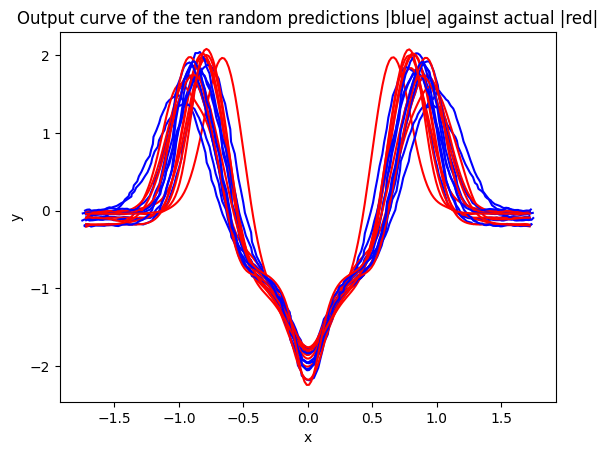

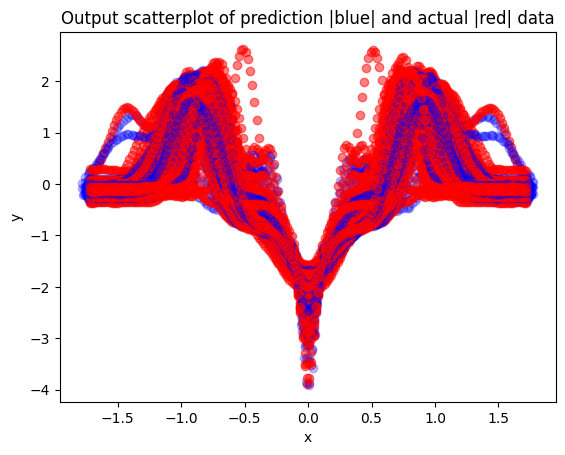

In [38]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=250),
             TensorBoard(log_dir='model_3_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=64, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

4/4 [==============================] - 0s 10ms/step


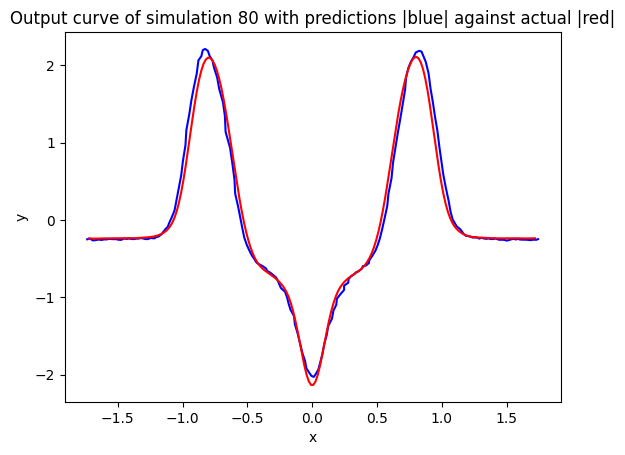

In [39]:
number = 80 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 10ms/step


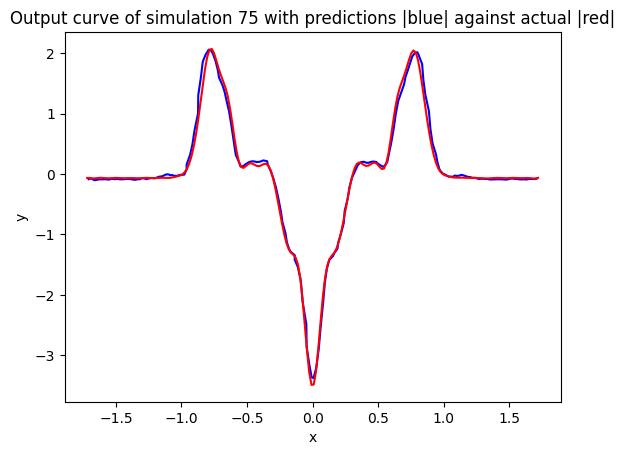

In [40]:
number = 75 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 9ms/step


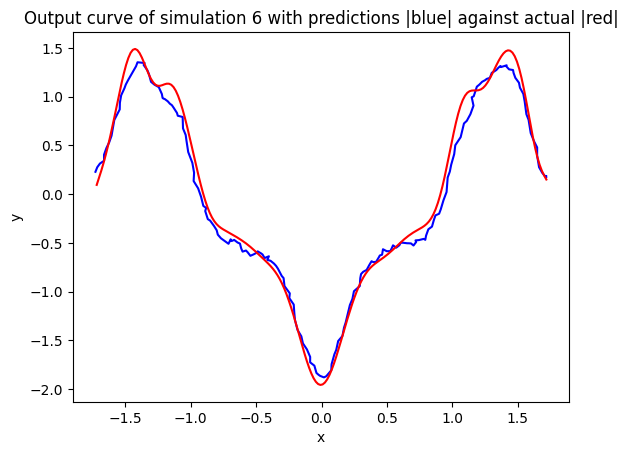

In [41]:
number = 6 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_16 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_12 (Dropout)        (None, 2000)              0         
                                                                 
 dense_17 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_13 (Dropout)        (None, 1000)              0         
                                                                 
 dense_18 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_14 (Dropout)        (None, 1000)              0   

7/7 [==============================] - 2s 342ms/step - loss: 0.1229 - val_loss: 0.1387
Epoch 62/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.1216 - val_loss: 0.1330
Epoch 63/1500
7/7 [==============================] - 1s 129ms/step - loss: 0.1223 - val_loss: 0.1392
Epoch 64/1500
7/7 [==============================] - 1s 132ms/step - loss: 0.1221 - val_loss: 0.1327
Epoch 65/1500
7/7 [==============================] - 1s 134ms/step - loss: 0.1185 - val_loss: 0.1313
Epoch 66/1500
7/7 [==============================] - 1s 131ms/step - loss: 0.1208 - val_loss: 0.1335
Epoch 67/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1219 - val_loss: 0.1359
Epoch 68/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.1173 - val_loss: 0.1344
Epoch 69/1500
7/7 [==============================] - 1s 125ms/step - loss: 0.1202 - val_loss: 0.1382
Epoch 70/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1178 - val_loss: 0.1341
Epoc

Epoch 142/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0974 - val_loss: 0.1170
Epoch 143/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0986 - val_loss: 0.1151
Epoch 144/1500
7/7 [==============================] - 1s 117ms/step - loss: 0.0969 - val_loss: 0.1153
Epoch 145/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0988 - val_loss: 0.1187
Epoch 146/1500
7/7 [==============================] - 2s 275ms/step - loss: 0.0980 - val_loss: 0.1186
Epoch 147/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0971 - val_loss: 0.1183
Epoch 148/1500
7/7 [==============================] - 1s 128ms/step - loss: 0.0970 - val_loss: 0.1190
Epoch 149/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0976 - val_loss: 0.1185
Epoch 150/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0970 - val_loss: 0.1195
Epoch 151/1500
7/7 [==============================] - 2s 294ms/step - loss: 0.0981

7/7 [==============================] - 1s 151ms/step - loss: 0.0853 - val_loss: 0.1026
Epoch 303/1500
7/7 [==============================] - 1s 233ms/step - loss: 0.0829 - val_loss: 0.1022
Epoch 304/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0827 - val_loss: 0.1036
Epoch 305/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0815 - val_loss: 0.1068
Epoch 306/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0830 - val_loss: 0.1023
Epoch 307/1500
7/7 [==============================] - 1s 115ms/step - loss: 0.0813 - val_loss: 0.1012
Epoch 308/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0869 - val_loss: 0.1029
Epoch 309/1500
7/7 [==============================] - 1s 132ms/step - loss: 0.0858 - val_loss: 0.1060
Epoch 310/1500
7/7 [==============================] - 1s 117ms/step - loss: 0.0860 - val_loss: 0.1042
Epoch 311/1500
7/7 [==============================] - 2s 300ms/step - loss: 0.0823 - val_loss: 0.

7/7 [==============================] - 1s 126ms/step - loss: 0.0707 - val_loss: 0.1011
Epoch 463/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0696 - val_loss: 0.0928
Epoch 464/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0718 - val_loss: 0.0943
Epoch 465/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0693 - val_loss: 0.0969
Epoch 466/1500
7/7 [==============================] - 1s 162ms/step - loss: 0.0703 - val_loss: 0.0990
Epoch 467/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0728 - val_loss: 0.0979
Epoch 468/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0721 - val_loss: 0.1002
Epoch 469/1500
7/7 [==============================] - 1s 115ms/step - loss: 0.0688 - val_loss: 0.0989
Epoch 470/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0670 - val_loss: 0.0973
Epoch 471/1500
7/7 [==============================] - 2s 301ms/step - loss: 0.0712 - val_loss: 0.

7/7 [==============================] - 1s 117ms/step - loss: 0.0638 - val_loss: 0.1022
Epoch 623/1500
7/7 [==============================] - 1s 125ms/step - loss: 0.0652 - val_loss: 0.1084
Epoch 624/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0652 - val_loss: 0.1059
Epoch 625/1500
7/7 [==============================] - 1s 117ms/step - loss: 0.0657 - val_loss: 0.1066
Epoch 626/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0617 - val_loss: 0.1085
Epoch 627/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0664 - val_loss: 0.1039
Epoch 628/1500
7/7 [==============================] - 1s 191ms/step - loss: 0.0721 - val_loss: 0.1033
Epoch 629/1500
7/7 [==============================] - 1s 198ms/step - loss: 0.0661 - val_loss: 0.1041
Epoch 630/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0656 - val_loss: 0.1031
Epoch 631/1500
7/7 [==============================] - 2s 305ms/step - loss: 0.0652 - val_loss: 0.

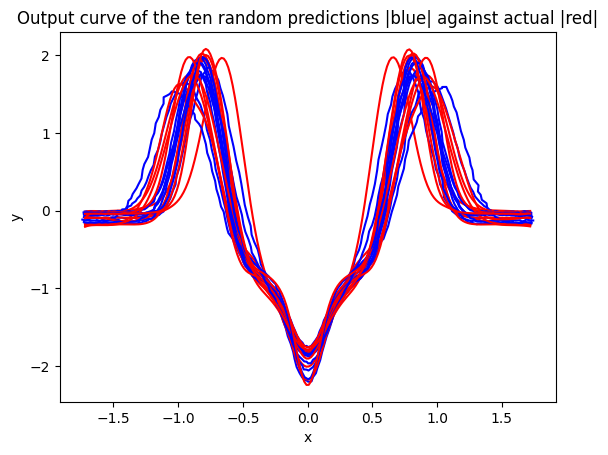

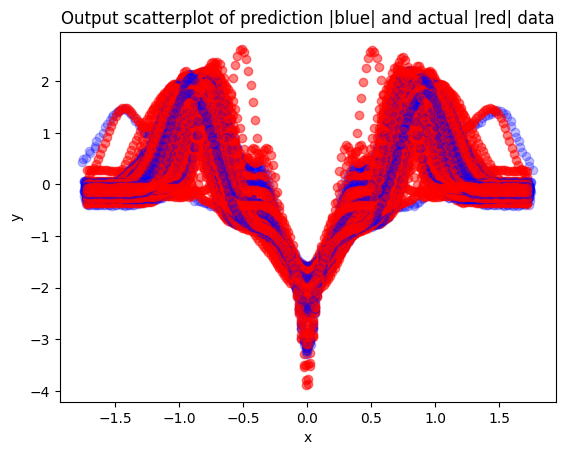

In [42]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_3_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=64, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

4/4 [==============================] - 0s 10ms/step


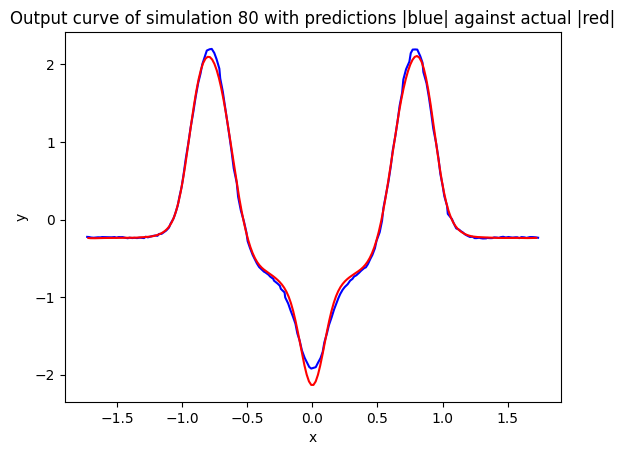

In [45]:
number = 80 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 12ms/step


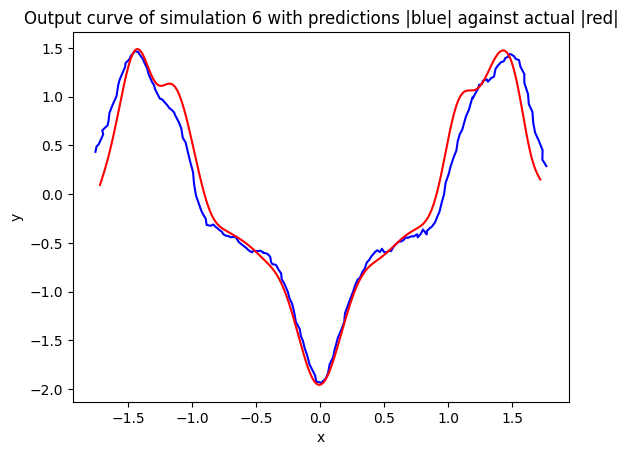

In [46]:
number = 6 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 12ms/step


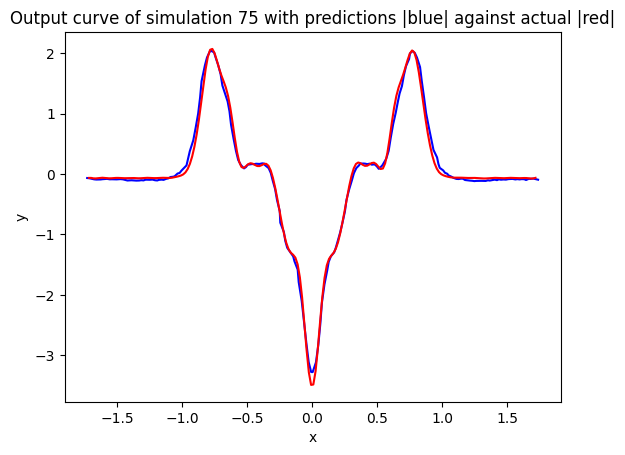

In [47]:
number = 75 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_23 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_17 (Dropout)        (None, 2000)              0         
                                                                 
 dense_24 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_18 (Dropout)        (None, 1000)              0         
                                                                 
 dense_25 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_19 (Dropout)        (None, 1000)              0   

7/7 [==============================] - 2s 356ms/step - loss: 0.1194 - val_loss: 0.1329
Epoch 62/1500
7/7 [==============================] - 1s 133ms/step - loss: 0.1182 - val_loss: 0.1393
Epoch 63/1500
7/7 [==============================] - 1s 132ms/step - loss: 0.1193 - val_loss: 0.1368
Epoch 64/1500
7/7 [==============================] - 1s 131ms/step - loss: 0.1184 - val_loss: 0.1337
Epoch 65/1500
7/7 [==============================] - 1s 132ms/step - loss: 0.1149 - val_loss: 0.1294
Epoch 66/1500
7/7 [==============================] - 1s 131ms/step - loss: 0.1120 - val_loss: 0.1392
Epoch 67/1500
7/7 [==============================] - 1s 130ms/step - loss: 0.1150 - val_loss: 0.1317
Epoch 68/1500
7/7 [==============================] - 1s 130ms/step - loss: 0.1147 - val_loss: 0.1308
Epoch 69/1500
7/7 [==============================] - 1s 133ms/step - loss: 0.1128 - val_loss: 0.1312
Epoch 70/1500
7/7 [==============================] - 1s 131ms/step - loss: 0.1096 - val_loss: 0.1288
Epoc

Epoch 142/1500
7/7 [==============================] - 1s 136ms/step - loss: 0.0975 - val_loss: 0.1194
Epoch 143/1500
7/7 [==============================] - 1s 133ms/step - loss: 0.0979 - val_loss: 0.1258
Epoch 144/1500
7/7 [==============================] - 1s 131ms/step - loss: 0.0999 - val_loss: 0.1196
Epoch 145/1500
7/7 [==============================] - 1s 134ms/step - loss: 0.0994 - val_loss: 0.1161
Epoch 146/1500
7/7 [==============================] - 1s 130ms/step - loss: 0.0978 - val_loss: 0.1187
Epoch 147/1500
7/7 [==============================] - 1s 131ms/step - loss: 0.1007 - val_loss: 0.1304
Epoch 148/1500
7/7 [==============================] - 1s 133ms/step - loss: 0.1026 - val_loss: 0.1205
Epoch 149/1500
7/7 [==============================] - 1s 134ms/step - loss: 0.1019 - val_loss: 0.1223
Epoch 150/1500
7/7 [==============================] - 1s 131ms/step - loss: 0.1007 - val_loss: 0.1192
Epoch 151/1500
7/7 [==============================] - 2s 352ms/step - loss: 0.0988

7/7 [==============================] - 1s 130ms/step - loss: 0.0825 - val_loss: 0.1076
Epoch 303/1500
7/7 [==============================] - 1s 137ms/step - loss: 0.0816 - val_loss: 0.1067
Epoch 304/1500
7/7 [==============================] - 1s 128ms/step - loss: 0.0800 - val_loss: 0.1062
Epoch 305/1500
7/7 [==============================] - 1s 129ms/step - loss: 0.0804 - val_loss: 0.1152
Epoch 306/1500
7/7 [==============================] - 1s 132ms/step - loss: 0.0860 - val_loss: 0.1067
Epoch 307/1500
7/7 [==============================] - 1s 130ms/step - loss: 0.0841 - val_loss: 0.1039
Epoch 308/1500
7/7 [==============================] - 1s 129ms/step - loss: 0.0798 - val_loss: 0.1032
Epoch 309/1500
7/7 [==============================] - 1s 129ms/step - loss: 0.0759 - val_loss: 0.1023
Epoch 310/1500
7/7 [==============================] - 1s 127ms/step - loss: 0.0801 - val_loss: 0.1062
Epoch 311/1500
7/7 [==============================] - 2s 340ms/step - loss: 0.0809 - val_loss: 0.

7/7 [==============================] - 1s 130ms/step - loss: 0.0819 - val_loss: 0.1057
Epoch 463/1500
7/7 [==============================] - 1s 127ms/step - loss: 0.0815 - val_loss: 0.1132
Epoch 464/1500
7/7 [==============================] - 1s 129ms/step - loss: 0.0795 - val_loss: 0.1097
Epoch 465/1500
7/7 [==============================] - 1s 125ms/step - loss: 0.0823 - val_loss: 0.1102
Epoch 466/1500
7/7 [==============================] - 1s 125ms/step - loss: 0.0801 - val_loss: 0.1084
Epoch 467/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0794 - val_loss: 0.1064
Epoch 468/1500
7/7 [==============================] - 1s 128ms/step - loss: 0.0793 - val_loss: 0.1104
Epoch 469/1500
7/7 [==============================] - 1s 128ms/step - loss: 0.0766 - val_loss: 0.1066
Epoch 470/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0740 - val_loss: 0.1051
Epoch 471/1500
7/7 [==============================] - 2s 348ms/step - loss: 0.0736 - val_loss: 0.

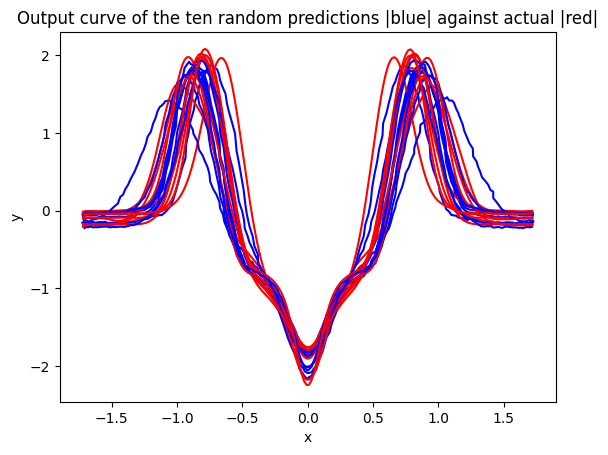

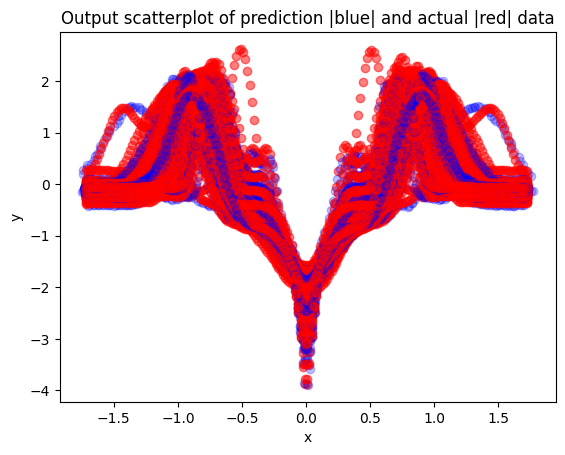

In [48]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.11, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.11, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.11, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.11, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=250),
             TensorBoard(log_dir='model_4_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=64, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

4/4 [==============================] - 0s 11ms/step


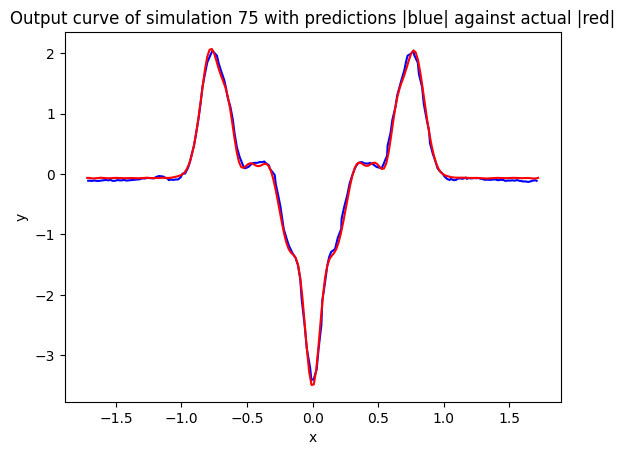

In [49]:
number = 75 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 11ms/step


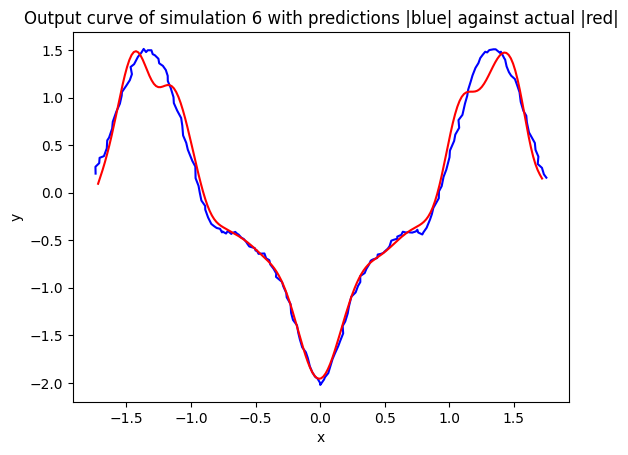

In [50]:
number = 6 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 12ms/step


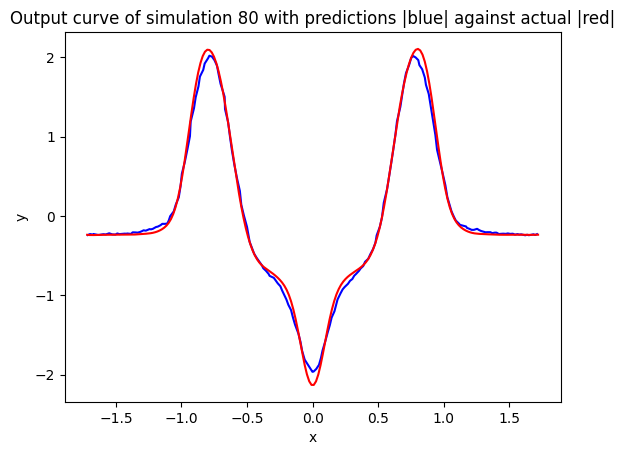

In [51]:
number = 80 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_30 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_22 (Dropout)        (None, 1000)              0         
                                                                 
 dense_31 (Dense)            (None, 900)               900900    
                                                                 
 dropout_23 (Dropout)        (None, 900)               0         
                                                                 
 dense_32 (Dense)            (None, 800)               720800    
                                                                 
 dropout_24 (Dropout)        (None, 800)               0   

7/7 [==============================] - 1s 77ms/step - loss: 0.0989 - val_loss: 0.1212
Epoch 143/1500
7/7 [==============================] - 1s 75ms/step - loss: 0.0978 - val_loss: 0.1247
Epoch 144/1500
7/7 [==============================] - 1s 181ms/step - loss: 0.0986 - val_loss: 0.1157
Epoch 145/1500
7/7 [==============================] - 1s 143ms/step - loss: 0.0964 - val_loss: 0.1159
Epoch 146/1500
7/7 [==============================] - 0s 74ms/step - loss: 0.0992 - val_loss: 0.1197
Epoch 147/1500
7/7 [==============================] - 1s 92ms/step - loss: 0.0958 - val_loss: 0.1181
Epoch 148/1500
7/7 [==============================] - 1s 128ms/step - loss: 0.0978 - val_loss: 0.1163
Epoch 149/1500
7/7 [==============================] - 0s 72ms/step - loss: 0.0952 - val_loss: 0.1151
Epoch 150/1500
7/7 [==============================] - 1s 76ms/step - loss: 0.0951 - val_loss: 0.1166
Epoch 151/1500
7/7 [==============================] - 2s 273ms/step - loss: 0.0960 - val_loss: 0.1183
E

7/7 [==============================] - 1s 74ms/step - loss: 0.0893 - val_loss: 0.1124
Epoch 224/1500
7/7 [==============================] - 0s 72ms/step - loss: 0.0906 - val_loss: 0.1124
Epoch 225/1500
7/7 [==============================] - 1s 77ms/step - loss: 0.0898 - val_loss: 0.1085
Epoch 226/1500
7/7 [==============================] - 0s 72ms/step - loss: 0.0888 - val_loss: 0.1093
Epoch 227/1500
7/7 [==============================] - 1s 74ms/step - loss: 0.0889 - val_loss: 0.1135
Epoch 228/1500
7/7 [==============================] - 1s 221ms/step - loss: 0.0898 - val_loss: 0.1130
Epoch 229/1500
7/7 [==============================] - 3s 436ms/step - loss: 0.0882 - val_loss: 0.1108
Epoch 230/1500
7/7 [==============================] - 2s 261ms/step - loss: 0.0916 - val_loss: 0.1095
Epoch 231/1500
7/7 [==============================] - 1s 178ms/step - loss: 0.0885 - val_loss: 0.1105
Epoch 232/1500
7/7 [==============================] - 1s 81ms/step - loss: 0.0889 - val_loss: 0.1122
E

7/7 [==============================] - 1s 78ms/step - loss: 0.0879 - val_loss: 0.1096
Epoch 305/1500
7/7 [==============================] - 1s 74ms/step - loss: 0.0841 - val_loss: 0.1022
Epoch 306/1500
7/7 [==============================] - 1s 78ms/step - loss: 0.0827 - val_loss: 0.1038
Epoch 307/1500
7/7 [==============================] - 0s 73ms/step - loss: 0.0806 - val_loss: 0.1075
Epoch 308/1500
7/7 [==============================] - 1s 78ms/step - loss: 0.0821 - val_loss: 0.1016
Epoch 309/1500
7/7 [==============================] - 1s 76ms/step - loss: 0.0798 - val_loss: 0.1030
Epoch 310/1500
7/7 [==============================] - 1s 77ms/step - loss: 0.0799 - val_loss: 0.1015
Epoch 311/1500
7/7 [==============================] - 1s 184ms/step - loss: 0.0800 - val_loss: 0.1006
Epoch 312/1500
7/7 [==============================] - 1s 76ms/step - loss: 0.0808 - val_loss: 0.1043
Epoch 313/1500
7/7 [==============================] - 1s 79ms/step - loss: 0.0814 - val_loss: 0.1071
Epoc

7/7 [==============================] - 0s 73ms/step - loss: 0.0773 - val_loss: 0.1007
Epoch 386/1500
7/7 [==============================] - 1s 78ms/step - loss: 0.0759 - val_loss: 0.1014
Epoch 387/1500
7/7 [==============================] - 1s 75ms/step - loss: 0.0816 - val_loss: 0.1000
Epoch 388/1500
7/7 [==============================] - 1s 94ms/step - loss: 0.0796 - val_loss: 0.0994
Epoch 389/1500
7/7 [==============================] - 1s 106ms/step - loss: 0.0756 - val_loss: 0.0979
Epoch 390/1500
7/7 [==============================] - 1s 94ms/step - loss: 0.0741 - val_loss: 0.1002
Epoch 391/1500
7/7 [==============================] - 1s 208ms/step - loss: 0.0742 - val_loss: 0.1015
Epoch 392/1500
7/7 [==============================] - 1s 100ms/step - loss: 0.0805 - val_loss: 0.1179
Epoch 393/1500
7/7 [==============================] - 1s 88ms/step - loss: 0.0895 - val_loss: 0.1146
Epoch 394/1500
7/7 [==============================] - 1s 86ms/step - loss: 0.0875 - val_loss: 0.1156
Ep

7/7 [==============================] - 1s 75ms/step - loss: 0.0709 - val_loss: 0.0984
Epoch 467/1500
7/7 [==============================] - 0s 72ms/step - loss: 0.0707 - val_loss: 0.0996
Epoch 468/1500
7/7 [==============================] - 1s 79ms/step - loss: 0.0715 - val_loss: 0.1012
Epoch 469/1500
7/7 [==============================] - 0s 73ms/step - loss: 0.0697 - val_loss: 0.0988
Epoch 470/1500
7/7 [==============================] - 1s 77ms/step - loss: 0.0725 - val_loss: 0.1007
Epoch 471/1500
7/7 [==============================] - 1s 183ms/step - loss: 0.0744 - val_loss: 0.1014
Epoch 472/1500
7/7 [==============================] - 0s 72ms/step - loss: 0.0778 - val_loss: 0.1007
Epoch 473/1500
7/7 [==============================] - 1s 74ms/step - loss: 0.0746 - val_loss: 0.1008
Epoch 474/1500
7/7 [==============================] - 0s 72ms/step - loss: 0.0787 - val_loss: 0.1011
Epoch 475/1500
7/7 [==============================] - 1s 74ms/step - loss: 0.0738 - val_loss: 0.1043
Epoc

7/7 [==============================] - 0s 72ms/step - loss: 0.0727 - val_loss: 0.1084
Epoch 629/1500
7/7 [==============================] - 1s 77ms/step - loss: 0.0816 - val_loss: 0.1178
Epoch 630/1500
7/7 [==============================] - 0s 72ms/step - loss: 0.0814 - val_loss: 0.1100
Epoch 631/1500
7/7 [==============================] - 1s 179ms/step - loss: 0.0782 - val_loss: 0.1106
Epoch 632/1500
7/7 [==============================] - 1s 77ms/step - loss: 0.0786 - val_loss: 0.1036
Epoch 633/1500
7/7 [==============================] - 1s 75ms/step - loss: 0.0720 - val_loss: 0.1020
Epoch 634/1500
7/7 [==============================] - 1s 78ms/step - loss: 0.0742 - val_loss: 0.1045
Epoch 635/1500
7/7 [==============================] - 0s 73ms/step - loss: 0.0776 - val_loss: 0.1108
Epoch 636/1500
7/7 [==============================] - 1s 78ms/step - loss: 0.0746 - val_loss: 0.1054
Epoch 637/1500
7/7 [==============================] - 0s 74ms/step - loss: 0.0716 - val_loss: 0.1011
Epoc

7/7 [==============================] - 1s 168ms/step - loss: 0.0751 - val_loss: 0.1217
Epoch 710/1500
7/7 [==============================] - 1s 171ms/step - loss: 0.0843 - val_loss: 0.1162
Epoch 711/1500
7/7 [==============================] - 3s 517ms/step - loss: 0.0793 - val_loss: 0.1157
Epoch 712/1500
7/7 [==============================] - 2s 255ms/step - loss: 0.0768 - val_loss: 0.1132
Epoch 713/1500
7/7 [==============================] - 2s 256ms/step - loss: 0.0775 - val_loss: 0.1103
Epoch 714/1500
7/7 [==============================] - 1s 125ms/step - loss: 0.0779 - val_loss: 0.1072
Epoch 715/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0741 - val_loss: 0.1074
Epoch 716/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0747 - val_loss: 0.1058
Epoch 717/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0721 - val_loss: 0.1082
Epoch 718/1500
7/7 [==============================] - 2s 367ms/step - loss: 0.0744 - val_loss: 0.

Epoch 790/1500
7/7 [==============================] - 0s 70ms/step - loss: 0.0572 - val_loss: 0.0996
Epoch 791/1500
7/7 [==============================] - 1s 178ms/step - loss: 0.0593 - val_loss: 0.0938
Epoch 792/1500
7/7 [==============================] - 0s 70ms/step - loss: 0.0618 - val_loss: 0.0950
Epoch 793/1500
7/7 [==============================] - 1s 74ms/step - loss: 0.0579 - val_loss: 0.1014
Epoch 794/1500
7/7 [==============================] - 0s 72ms/step - loss: 0.0633 - val_loss: 0.0995
Epoch 795/1500
7/7 [==============================] - 1s 74ms/step - loss: 0.0612 - val_loss: 0.0981
Epoch 796/1500
7/7 [==============================] - 1s 76ms/step - loss: 0.0587 - val_loss: 0.0966
Epoch 797/1500
7/7 [==============================] - 1s 75ms/step - loss: 0.0588 - val_loss: 0.0993
Epoch 798/1500
7/7 [==============================] - 1s 75ms/step - loss: 0.0581 - val_loss: 0.0983
Epoch 799/1500
7/7 [==============================] - 1s 81ms/step - loss: 0.0576 - val_lo

7/7 [==============================] - 2s 252ms/step - loss: 0.0627 - val_loss: 0.1016
Epoch 872/1500
7/7 [==============================] - 0s 73ms/step - loss: 0.0628 - val_loss: 0.1031
Epoch 873/1500
7/7 [==============================] - 1s 75ms/step - loss: 0.0582 - val_loss: 0.1005
Epoch 874/1500
7/7 [==============================] - 1s 206ms/step - loss: 0.0601 - val_loss: 0.1031
Epoch 875/1500
7/7 [==============================] - 1s 75ms/step - loss: 0.0675 - val_loss: 0.1020
Epoch 876/1500
7/7 [==============================] - 2s 277ms/step - loss: 0.0669 - val_loss: 0.1007
Epoch 877/1500
7/7 [==============================] - 0s 73ms/step - loss: 0.0654 - val_loss: 0.1044
Epoch 878/1500
7/7 [==============================] - 1s 77ms/step - loss: 0.0612 - val_loss: 0.1043
Epoch 879/1500
7/7 [==============================] - 2s 302ms/step - loss: 0.0625 - val_loss: 0.1031
Epoch 880/1500
7/7 [==============================] - 1s 76ms/step - loss: 0.0586 - val_loss: 0.1021
E

7/7 [==============================] - 1s 76ms/step - loss: 0.0617 - val_loss: 0.1008
Epoch 953/1500
7/7 [==============================] - 0s 70ms/step - loss: 0.0622 - val_loss: 0.1009
Epoch 954/1500
7/7 [==============================] - 1s 76ms/step - loss: 0.0618 - val_loss: 0.0978
Epoch 955/1500
7/7 [==============================] - 0s 73ms/step - loss: 0.0604 - val_loss: 0.1040
Epoch 956/1500
7/7 [==============================] - 1s 76ms/step - loss: 0.0608 - val_loss: 0.0971
Epoch 957/1500
7/7 [==============================] - 1s 79ms/step - loss: 0.0624 - val_loss: 0.1018
Epoch 958/1500
7/7 [==============================] - 1s 79ms/step - loss: 0.0620 - val_loss: 0.1001
Epoch 959/1500
7/7 [==============================] - 0s 73ms/step - loss: 0.0593 - val_loss: 0.1022
Epoch 960/1500
7/7 [==============================] - 1s 77ms/step - loss: 0.0607 - val_loss: 0.1000
Epoch 961/1500
7/7 [==============================] - 1s 182ms/step - loss: 0.0568 - val_loss: 0.1041
Epoc

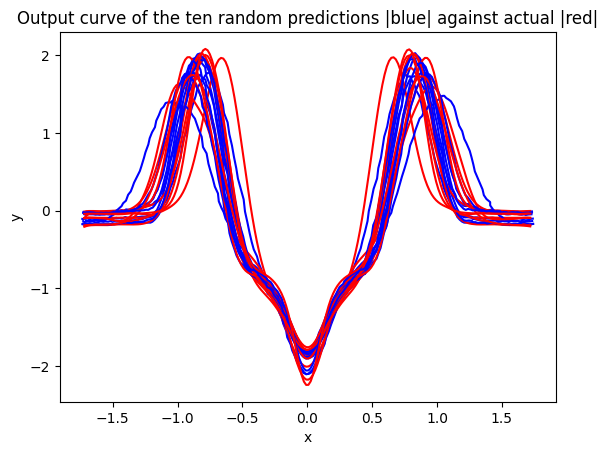

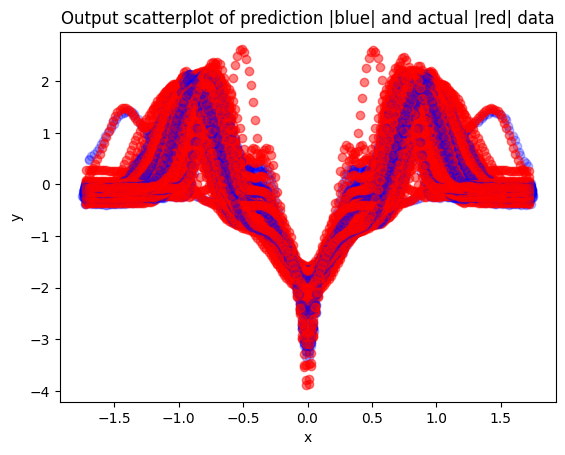

In [52]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(1000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(900, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(800, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(700, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(600, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=250),
             TensorBoard(log_dir='model_4_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=64, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

4/4 [==============================] - 0s 9ms/step


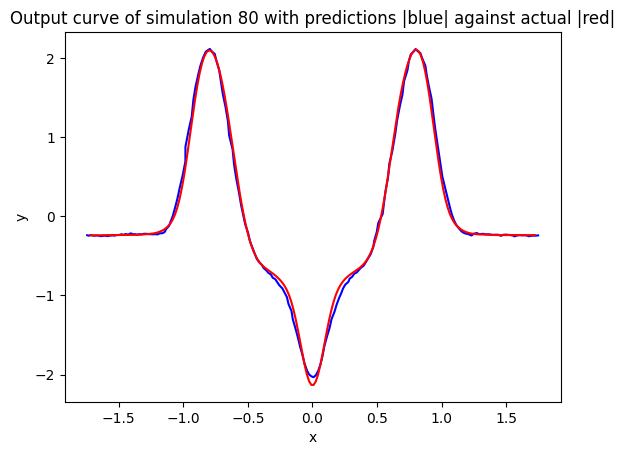

In [53]:
number = 80 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 10ms/step


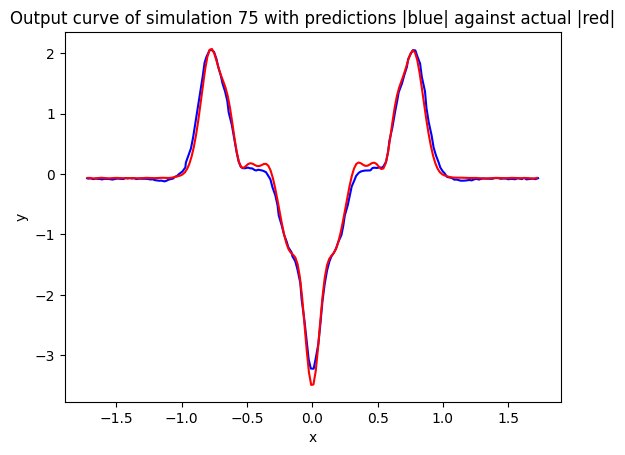

In [54]:
number = 75 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 8ms/step


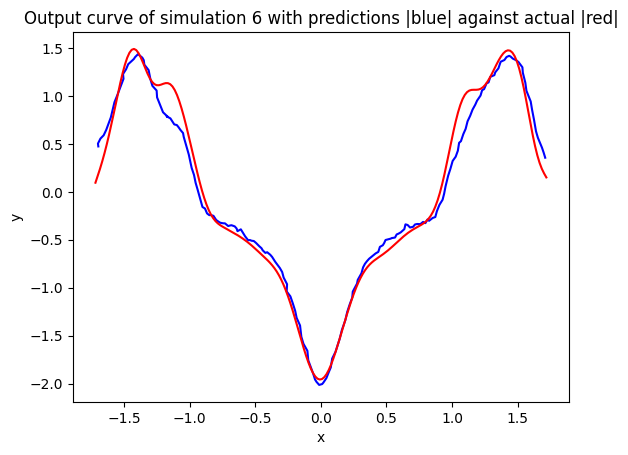

In [55]:
number = 6 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 2000)              2002000   
                                                                 
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 1500)              3001500   
                                                                 
 dropout_1 (Dropout)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_2 (Dropout)         (None, 1500)              0     

Epoch 140/1500
7/7 [==============================] - 1s 198ms/step - loss: 0.1132 - val_loss: 0.1249
Epoch 141/1500
7/7 [==============================] - 3s 551ms/step - loss: 0.1146 - val_loss: 0.1212
Epoch 142/1500
7/7 [==============================] - 1s 201ms/step - loss: 0.1095 - val_loss: 0.1227
Epoch 143/1500
7/7 [==============================] - 1s 212ms/step - loss: 0.1119 - val_loss: 0.1284
Epoch 144/1500
7/7 [==============================] - 1s 215ms/step - loss: 0.1103 - val_loss: 0.1286
Epoch 145/1500
7/7 [==============================] - 1s 214ms/step - loss: 0.1114 - val_loss: 0.1205
Epoch 146/1500
7/7 [==============================] - 1s 215ms/step - loss: 0.1093 - val_loss: 0.1199
Epoch 147/1500
7/7 [==============================] - 1s 197ms/step - loss: 0.1079 - val_loss: 0.1213
Epoch 148/1500
7/7 [==============================] - 1s 215ms/step - loss: 0.1090 - val_loss: 0.1224
Epoch 149/1500
7/7 [==============================] - 1s 202ms/step - loss: 0.1082

7/7 [==============================] - 1s 211ms/step - loss: 0.1056 - val_loss: 0.1163
Epoch 301/1500
7/7 [==============================] - 3s 541ms/step - loss: 0.1032 - val_loss: 0.1198
Epoch 302/1500
7/7 [==============================] - 1s 206ms/step - loss: 0.1030 - val_loss: 0.1224
Epoch 303/1500
7/7 [==============================] - 1s 205ms/step - loss: 0.1042 - val_loss: 0.1190
Epoch 304/1500
7/7 [==============================] - 1s 205ms/step - loss: 0.1066 - val_loss: 0.1198
Epoch 305/1500
7/7 [==============================] - 1s 203ms/step - loss: 0.1001 - val_loss: 0.1171
Epoch 306/1500
7/7 [==============================] - 1s 200ms/step - loss: 0.1037 - val_loss: 0.1153
Epoch 307/1500
7/7 [==============================] - 1s 206ms/step - loss: 0.1040 - val_loss: 0.1206
Epoch 308/1500
7/7 [==============================] - 1s 201ms/step - loss: 0.1037 - val_loss: 0.1184
Epoch 309/1500
7/7 [==============================] - 1s 206ms/step - loss: 0.1018 - val_loss: 0.

7/7 [==============================] - 1s 206ms/step - loss: 0.0998 - val_loss: 0.1194
Epoch 461/1500
7/7 [==============================] - 4s 561ms/step - loss: 0.1009 - val_loss: 0.1169
Epoch 462/1500
7/7 [==============================] - 1s 204ms/step - loss: 0.1002 - val_loss: 0.1192
Epoch 463/1500
7/7 [==============================] - 1s 208ms/step - loss: 0.1017 - val_loss: 0.1224
Epoch 464/1500
7/7 [==============================] - 1s 213ms/step - loss: 0.1025 - val_loss: 0.1193
Epoch 465/1500
7/7 [==============================] - 1s 204ms/step - loss: 0.1008 - val_loss: 0.1241
Epoch 466/1500
7/7 [==============================] - 2s 323ms/step - loss: 0.1033 - val_loss: 0.1215
Epoch 467/1500
7/7 [==============================] - 2s 249ms/step - loss: 0.1018 - val_loss: 0.1172
Epoch 468/1500
7/7 [==============================] - 2s 219ms/step - loss: 0.1005 - val_loss: 0.1151
Epoch 469/1500
7/7 [==============================] - 2s 221ms/step - loss: 0.1005 - val_loss: 0.

7/7 [==============================] - 2s 236ms/step - loss: 0.0961 - val_loss: 0.1087
Epoch 621/1500
7/7 [==============================] - 3s 537ms/step - loss: 0.0936 - val_loss: 0.1115
Epoch 622/1500
7/7 [==============================] - 1s 199ms/step - loss: 0.0972 - val_loss: 0.1112
Epoch 623/1500
7/7 [==============================] - 1s 199ms/step - loss: 0.0956 - val_loss: 0.1109
Epoch 624/1500
7/7 [==============================] - 1s 202ms/step - loss: 0.0967 - val_loss: 0.1114
Epoch 625/1500
7/7 [==============================] - 1s 209ms/step - loss: 0.0957 - val_loss: 0.1099
Epoch 626/1500
7/7 [==============================] - 1s 195ms/step - loss: 0.0968 - val_loss: 0.1101
Epoch 627/1500
7/7 [==============================] - 2s 232ms/step - loss: 0.0973 - val_loss: 0.1106
Epoch 628/1500
7/7 [==============================] - 2s 217ms/step - loss: 0.0945 - val_loss: 0.1108
Epoch 629/1500
7/7 [==============================] - 1s 217ms/step - loss: 0.0944 - val_loss: 0.

7/7 [==============================] - 2s 302ms/step - loss: 0.0980 - val_loss: 0.1179
Epoch 781/1500
7/7 [==============================] - 5s 792ms/step - loss: 0.0996 - val_loss: 0.1153
Epoch 782/1500
7/7 [==============================] - 1s 208ms/step - loss: 0.0997 - val_loss: 0.1160
Epoch 783/1500
7/7 [==============================] - 2s 219ms/step - loss: 0.0963 - val_loss: 0.1205
Epoch 784/1500
7/7 [==============================] - 2s 316ms/step - loss: 0.0978 - val_loss: 0.1216
Epoch 785/1500
7/7 [==============================] - 1s 207ms/step - loss: 0.1051 - val_loss: 0.1206
Epoch 786/1500
7/7 [==============================] - 2s 378ms/step - loss: 0.1009 - val_loss: 0.1184
Epoch 787/1500
7/7 [==============================] - 1s 218ms/step - loss: 0.1020 - val_loss: 0.1156
Epoch 788/1500
7/7 [==============================] - 1s 209ms/step - loss: 0.1005 - val_loss: 0.1169
Epoch 789/1500
7/7 [==============================] - 3s 411ms/step - loss: 0.0987 - val_loss: 0.

7/7 [==============================] - 1s 211ms/step - loss: 0.1036 - val_loss: 0.1249
Epoch 941/1500
7/7 [==============================] - 3s 545ms/step - loss: 0.0995 - val_loss: 0.1247
Epoch 942/1500
7/7 [==============================] - 1s 211ms/step - loss: 0.1034 - val_loss: 0.1247
Epoch 943/1500
7/7 [==============================] - 1s 211ms/step - loss: 0.0985 - val_loss: 0.1212
Epoch 944/1500
7/7 [==============================] - 2s 378ms/step - loss: 0.0967 - val_loss: 0.1195
Epoch 945/1500
7/7 [==============================] - 1s 211ms/step - loss: 0.0973 - val_loss: 0.1180
Epoch 946/1500
7/7 [==============================] - 1s 213ms/step - loss: 0.0985 - val_loss: 0.1205
Epoch 947/1500
7/7 [==============================] - 1s 210ms/step - loss: 0.0965 - val_loss: 0.1208
Epoch 948/1500
7/7 [==============================] - 1s 196ms/step - loss: 0.0978 - val_loss: 0.1202
Epoch 949/1500
7/7 [==============================] - 1s 207ms/step - loss: 0.0990 - val_loss: 0.

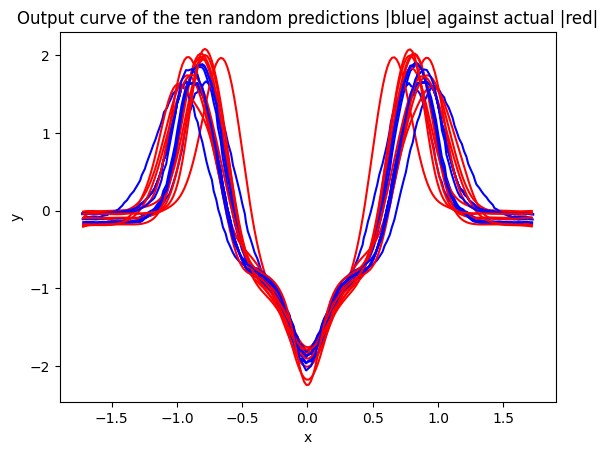

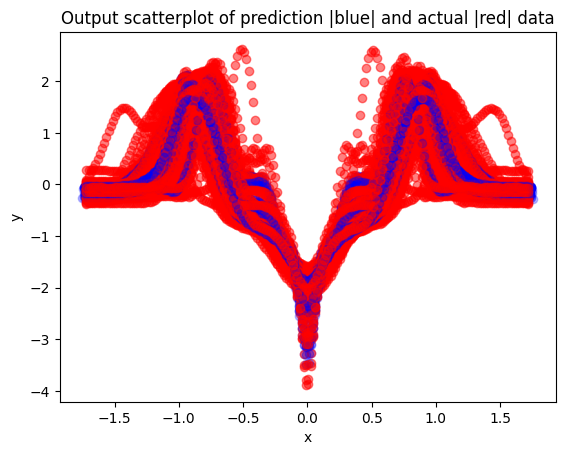

In [11]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(1500, activation="relu")(x)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(1500, activation="relu")(x)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(1500, activation="relu")(x)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(1500, activation="relu")(x)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.20, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=250),
             TensorBoard(log_dir='model_4_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=64, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_7 (Dense)             (None, 2000)              2002000   
                                                                 
 dropout_6 (Dropout)         (None, 2000)              0         
                                                                 
 dense_8 (Dense)             (None, 1500)              3001500   
                                                                 
 dropout_7 (Dropout)         (None, 1500)              0         
                                                                 
 dense_9 (Dense)             (None, 1500)              2251500   
                                                                 
 dropout_8 (Dropout)         (None, 1500)              0   

7/7 [==============================] - 3s 543ms/step - loss: 0.1377 - val_loss: 0.1437
Epoch 62/1500
7/7 [==============================] - 2s 221ms/step - loss: 0.1363 - val_loss: 0.1448
Epoch 63/1500
7/7 [==============================] - 1s 204ms/step - loss: 0.1364 - val_loss: 0.1436
Epoch 64/1500
7/7 [==============================] - 1s 217ms/step - loss: 0.1353 - val_loss: 0.1418
Epoch 65/1500
7/7 [==============================] - 1s 216ms/step - loss: 0.1353 - val_loss: 0.1474
Epoch 66/1500
7/7 [==============================] - 1s 216ms/step - loss: 0.1351 - val_loss: 0.1399
Epoch 67/1500
7/7 [==============================] - 1s 200ms/step - loss: 0.1319 - val_loss: 0.1379
Epoch 68/1500
7/7 [==============================] - 1s 217ms/step - loss: 0.1299 - val_loss: 0.1452
Epoch 69/1500
7/7 [==============================] - 1s 211ms/step - loss: 0.1309 - val_loss: 0.1391
Epoch 70/1500
7/7 [==============================] - 2s 345ms/step - loss: 0.1286 - val_loss: 0.1361
Epoc

Epoch 142/1500
7/7 [==============================] - 2s 224ms/step - loss: 0.1100 - val_loss: 0.1273
Epoch 143/1500
7/7 [==============================] - 1s 209ms/step - loss: 0.1071 - val_loss: 0.1361
Epoch 144/1500
7/7 [==============================] - 2s 227ms/step - loss: 0.1156 - val_loss: 0.1275
Epoch 145/1500
7/7 [==============================] - 1s 209ms/step - loss: 0.1117 - val_loss: 0.1311
Epoch 146/1500
7/7 [==============================] - 1s 212ms/step - loss: 0.1139 - val_loss: 0.1360
Epoch 147/1500
7/7 [==============================] - 1s 215ms/step - loss: 0.1172 - val_loss: 0.1312
Epoch 148/1500
7/7 [==============================] - 1s 202ms/step - loss: 0.1142 - val_loss: 0.1247
Epoch 149/1500
7/7 [==============================] - 1s 210ms/step - loss: 0.1118 - val_loss: 0.1263
Epoch 150/1500
7/7 [==============================] - 1s 200ms/step - loss: 0.1157 - val_loss: 0.1431
Epoch 151/1500
7/7 [==============================] - 4s 555ms/step - loss: 0.1174

7/7 [==============================] - 2s 225ms/step - loss: 0.0969 - val_loss: 0.1200
Epoch 303/1500
7/7 [==============================] - 1s 204ms/step - loss: 0.0958 - val_loss: 0.1181
Epoch 304/1500
7/7 [==============================] - 1s 218ms/step - loss: 0.0978 - val_loss: 0.1199
Epoch 305/1500
7/7 [==============================] - 1s 201ms/step - loss: 0.0977 - val_loss: 0.1200
Epoch 306/1500
7/7 [==============================] - 1s 214ms/step - loss: 0.0971 - val_loss: 0.1205
Epoch 307/1500
7/7 [==============================] - 1s 199ms/step - loss: 0.0966 - val_loss: 0.1198
Epoch 308/1500
7/7 [==============================] - 1s 220ms/step - loss: 0.0961 - val_loss: 0.1198
Epoch 309/1500
7/7 [==============================] - 1s 214ms/step - loss: 0.0957 - val_loss: 0.1195
Epoch 310/1500
7/7 [==============================] - 1s 215ms/step - loss: 0.0971 - val_loss: 0.1235
Epoch 311/1500
7/7 [==============================] - 4s 555ms/step - loss: 0.1004 - val_loss: 0.

7/7 [==============================] - 1s 215ms/step - loss: 0.0954 - val_loss: 0.1194
Epoch 463/1500
7/7 [==============================] - 1s 201ms/step - loss: 0.0958 - val_loss: 0.1193
Epoch 464/1500
7/7 [==============================] - 1s 211ms/step - loss: 0.0926 - val_loss: 0.1195
Epoch 465/1500
7/7 [==============================] - 1s 211ms/step - loss: 0.0972 - val_loss: 0.1196
Epoch 466/1500
7/7 [==============================] - 1s 222ms/step - loss: 0.0919 - val_loss: 0.1191
Epoch 467/1500
7/7 [==============================] - 2s 231ms/step - loss: 0.0968 - val_loss: 0.1189
Epoch 468/1500
7/7 [==============================] - 2s 216ms/step - loss: 0.0949 - val_loss: 0.1202
Epoch 469/1500
7/7 [==============================] - 1s 222ms/step - loss: 0.0954 - val_loss: 0.1190
Epoch 470/1500
7/7 [==============================] - 1s 207ms/step - loss: 0.0975 - val_loss: 0.1211
Epoch 471/1500
7/7 [==============================] - 3s 552ms/step - loss: 0.0964 - val_loss: 0.

7/7 [==============================] - 1s 213ms/step - loss: 0.0953 - val_loss: 0.1189
Epoch 623/1500
7/7 [==============================] - 1s 211ms/step - loss: 0.0916 - val_loss: 0.1182
Epoch 624/1500
7/7 [==============================] - 1s 212ms/step - loss: 0.1029 - val_loss: 0.1264
Epoch 625/1500
7/7 [==============================] - 1s 198ms/step - loss: 0.1000 - val_loss: 0.1236
Epoch 626/1500
7/7 [==============================] - 1s 211ms/step - loss: 0.0968 - val_loss: 0.1203
Epoch 627/1500
7/7 [==============================] - 1s 212ms/step - loss: 0.0937 - val_loss: 0.1225
Epoch 628/1500
7/7 [==============================] - 1s 217ms/step - loss: 0.0918 - val_loss: 0.1210
Epoch 629/1500
7/7 [==============================] - 1s 214ms/step - loss: 0.0924 - val_loss: 0.1199
Epoch 630/1500
7/7 [==============================] - 2s 219ms/step - loss: 0.0908 - val_loss: 0.1201
Epoch 631/1500
7/7 [==============================] - 4s 591ms/step - loss: 0.0905 - val_loss: 0.

7/7 [==============================] - 1s 218ms/step - loss: 0.0976 - val_loss: 0.1204
Epoch 783/1500
7/7 [==============================] - 1s 204ms/step - loss: 0.0969 - val_loss: 0.1199
Epoch 784/1500
7/7 [==============================] - 1s 212ms/step - loss: 0.0925 - val_loss: 0.1216
Epoch 785/1500
7/7 [==============================] - 1s 217ms/step - loss: 0.0927 - val_loss: 0.1269
Epoch 786/1500
7/7 [==============================] - 1s 216ms/step - loss: 0.0958 - val_loss: 0.1208
Epoch 787/1500
7/7 [==============================] - 1s 212ms/step - loss: 0.0932 - val_loss: 0.1205
Epoch 788/1500
7/7 [==============================] - 1s 213ms/step - loss: 0.0901 - val_loss: 0.1200
Epoch 789/1500
7/7 [==============================] - 1s 213ms/step - loss: 0.0918 - val_loss: 0.1202
Epoch 790/1500
7/7 [==============================] - 1s 200ms/step - loss: 0.0939 - val_loss: 0.1212
Epoch 791/1500
7/7 [==============================] - 3s 549ms/step - loss: 0.0916 - val_loss: 0.

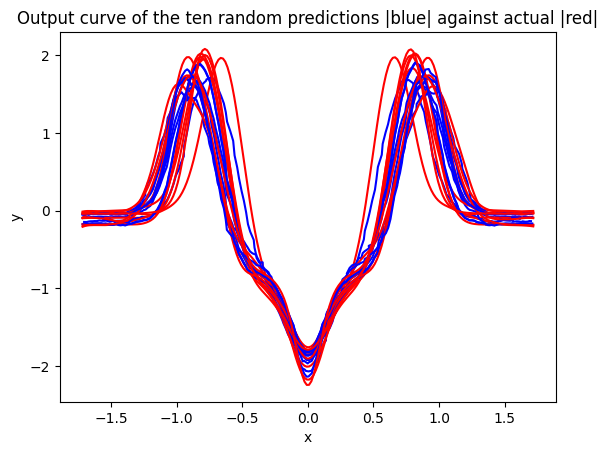

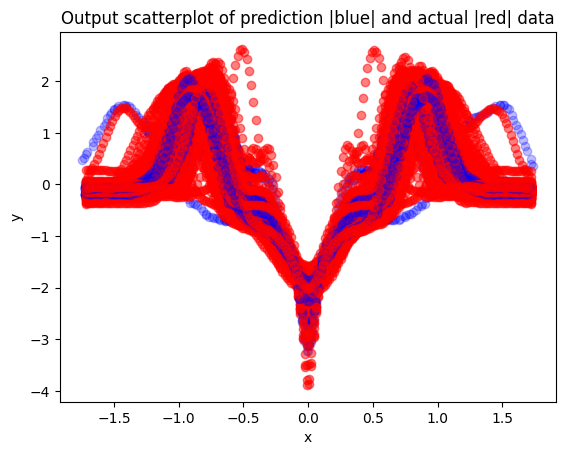

In [12]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(1500, activation="relu")(x)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(1500, activation="relu")(x)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(1500, activation="relu")(x)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(1500, activation="relu")(x)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=200),
             TensorBoard(log_dir='model_4_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=64, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_14 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_11 (Dropout)        (None, 2000)              0         
                                                                 
 dense_15 (Dense)            (None, 2000)              4002000   
                                                                 
 dropout_12 (Dropout)        (None, 2000)              0         
                                                                 
 dense_16 (Dense)            (None, 2000)              4002000   
                                                                 
 dropout_13 (Dropout)        (None, 2000)              0   

7/7 [==============================] - 5s 869ms/step - loss: 0.1353 - val_loss: 0.1434
Epoch 62/1500
7/7 [==============================] - 2s 342ms/step - loss: 0.1357 - val_loss: 0.1450
Epoch 63/1500
7/7 [==============================] - 2s 331ms/step - loss: 0.1355 - val_loss: 0.1447
Epoch 64/1500
7/7 [==============================] - 2s 334ms/step - loss: 0.1350 - val_loss: 0.1488
Epoch 65/1500
7/7 [==============================] - 2s 330ms/step - loss: 0.1366 - val_loss: 0.1516
Epoch 66/1500
7/7 [==============================] - 2s 331ms/step - loss: 0.1383 - val_loss: 0.1559
Epoch 67/1500
7/7 [==============================] - 2s 330ms/step - loss: 0.1399 - val_loss: 0.1445
Epoch 68/1500
7/7 [==============================] - 2s 324ms/step - loss: 0.1367 - val_loss: 0.1457
Epoch 69/1500
7/7 [==============================] - 3s 399ms/step - loss: 0.1350 - val_loss: 0.1429
Epoch 70/1500
7/7 [==============================] - 2s 319ms/step - loss: 0.1335 - val_loss: 0.1440
Epoc

Epoch 142/1500
7/7 [==============================] - 2s 328ms/step - loss: 0.1008 - val_loss: 0.1236
Epoch 143/1500
7/7 [==============================] - 2s 346ms/step - loss: 0.1015 - val_loss: 0.1262
Epoch 144/1500
7/7 [==============================] - 3s 427ms/step - loss: 0.1054 - val_loss: 0.1244
Epoch 145/1500
7/7 [==============================] - 2s 344ms/step - loss: 0.1044 - val_loss: 0.1245
Epoch 146/1500
7/7 [==============================] - 2s 347ms/step - loss: 0.1032 - val_loss: 0.1225
Epoch 147/1500
7/7 [==============================] - 2s 336ms/step - loss: 0.1022 - val_loss: 0.1212
Epoch 148/1500
7/7 [==============================] - 2s 348ms/step - loss: 0.1018 - val_loss: 0.1221
Epoch 149/1500
7/7 [==============================] - 2s 349ms/step - loss: 0.1006 - val_loss: 0.1217
Epoch 150/1500
7/7 [==============================] - 2s 339ms/step - loss: 0.0987 - val_loss: 0.1300
Epoch 151/1500
7/7 [==============================] - 6s 925ms/step - loss: 0.1026

7/7 [==============================] - 2s 338ms/step - loss: 0.0818 - val_loss: 0.1105
Epoch 303/1500
7/7 [==============================] - 2s 328ms/step - loss: 0.0868 - val_loss: 0.1076
Epoch 304/1500
7/7 [==============================] - 2s 316ms/step - loss: 0.0830 - val_loss: 0.1089
Epoch 305/1500
7/7 [==============================] - 2s 334ms/step - loss: 0.0809 - val_loss: 0.1033
Epoch 306/1500
7/7 [==============================] - 2s 322ms/step - loss: 0.0810 - val_loss: 0.1046
Epoch 307/1500
7/7 [==============================] - 2s 327ms/step - loss: 0.0823 - val_loss: 0.1076
Epoch 308/1500
7/7 [==============================] - 2s 328ms/step - loss: 0.0833 - val_loss: 0.1105
Epoch 309/1500
7/7 [==============================] - 2s 333ms/step - loss: 0.0843 - val_loss: 0.1037
Epoch 310/1500
7/7 [==============================] - 2s 325ms/step - loss: 0.0829 - val_loss: 0.1075
Epoch 311/1500
7/7 [==============================] - 6s 874ms/step - loss: 0.0863 - val_loss: 0.

7/7 [==============================] - 2s 332ms/step - loss: 0.0845 - val_loss: 0.1171
Epoch 463/1500
7/7 [==============================] - 2s 342ms/step - loss: 0.0906 - val_loss: 0.1159
Epoch 464/1500
7/7 [==============================] - 2s 332ms/step - loss: 0.0883 - val_loss: 0.1121
Epoch 465/1500
7/7 [==============================] - 2s 333ms/step - loss: 0.0847 - val_loss: 0.1097
Epoch 466/1500
7/7 [==============================] - 2s 327ms/step - loss: 0.0818 - val_loss: 0.1090
Epoch 467/1500
7/7 [==============================] - 2s 328ms/step - loss: 0.0808 - val_loss: 0.1103
Epoch 468/1500
7/7 [==============================] - 2s 332ms/step - loss: 0.0816 - val_loss: 0.1080
Epoch 469/1500
7/7 [==============================] - 2s 327ms/step - loss: 0.0786 - val_loss: 0.1138
Epoch 470/1500
7/7 [==============================] - 2s 332ms/step - loss: 0.0855 - val_loss: 0.1122
Epoch 471/1500
7/7 [==============================] - 6s 889ms/step - loss: 0.0854 - val_loss: 0.

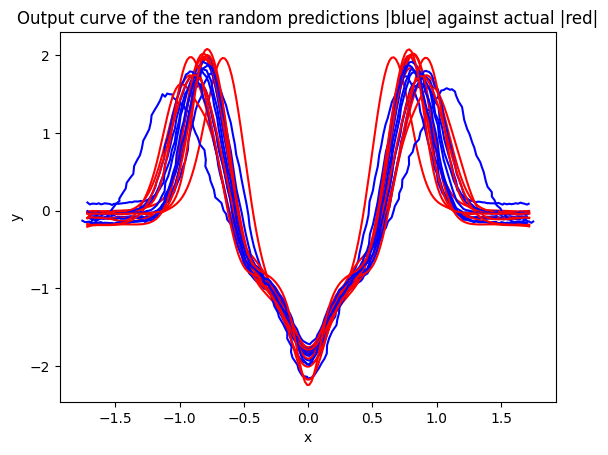

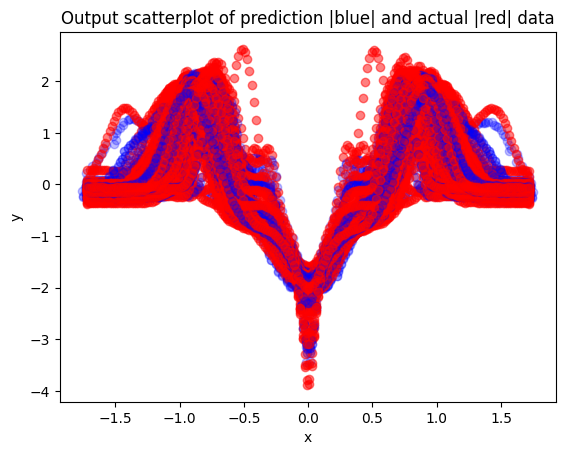

In [13]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=200),
             TensorBoard(log_dir='model_4_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=64, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

4/4 [==============================] - 0s 27ms/step


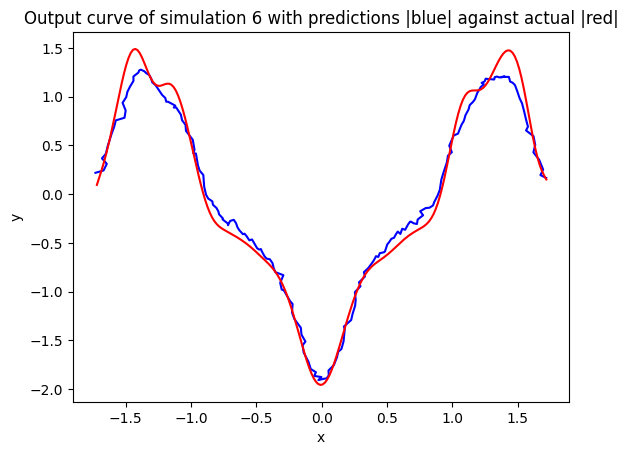

In [14]:
number = 6 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 26ms/step


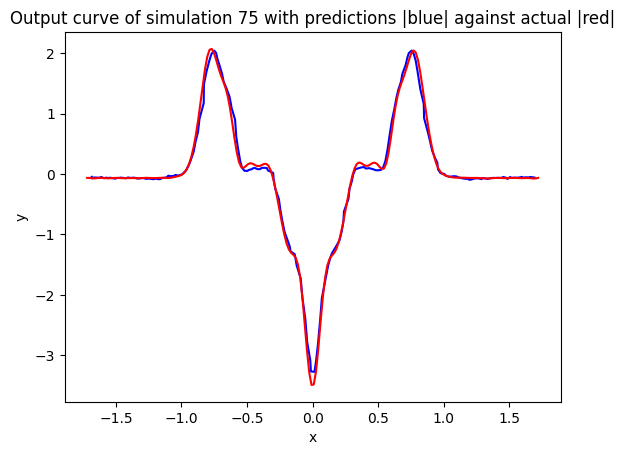

In [15]:
number = 75 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 28ms/step


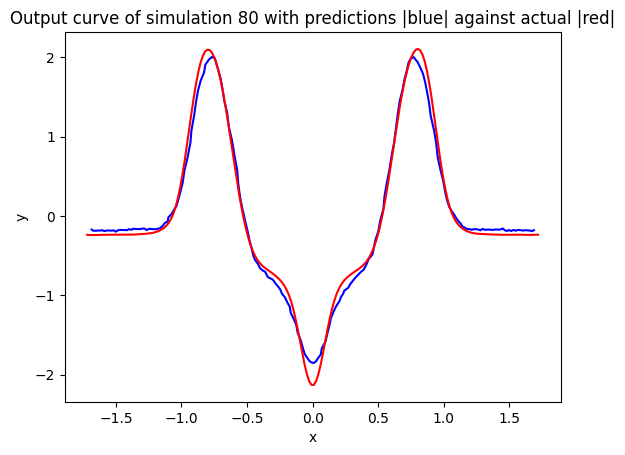

In [16]:
number = 80 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_21 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_16 (Dropout)        (None, 2000)              0         
                                                                 
 dense_22 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_17 (Dropout)        (None, 1000)              0         
                                                                 
 dense_23 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_18 (Dropout)        (None, 1000)              0   

Epoch 60/1500
13/13 [==============================] - 1s 115ms/step - loss: 0.1106 - val_loss: 0.1295
Epoch 61/1500
13/13 [==============================] - 3s 209ms/step - loss: 0.1087 - val_loss: 0.1298
Epoch 62/1500
13/13 [==============================] - 2s 191ms/step - loss: 0.1097 - val_loss: 0.1286
Epoch 63/1500
13/13 [==============================] - 1s 111ms/step - loss: 0.1101 - val_loss: 0.1286
Epoch 64/1500
13/13 [==============================] - 1s 115ms/step - loss: 0.1096 - val_loss: 0.1314
Epoch 65/1500
13/13 [==============================] - 1s 116ms/step - loss: 0.1080 - val_loss: 0.1296
Epoch 66/1500
13/13 [==============================] - 2s 119ms/step - loss: 0.1082 - val_loss: 0.1386
Epoch 67/1500
13/13 [==============================] - 1s 117ms/step - loss: 0.1098 - val_loss: 0.1263
Epoch 68/1500
13/13 [==============================] - 1s 116ms/step - loss: 0.1070 - val_loss: 0.1243
Epoch 69/1500
13/13 [==============================] - 1s 116ms/step - lo

Epoch 218/1500
13/13 [==============================] - 1s 109ms/step - loss: 0.0827 - val_loss: 0.1104
Epoch 219/1500
13/13 [==============================] - 2s 119ms/step - loss: 0.0836 - val_loss: 0.1092
Epoch 220/1500
13/13 [==============================] - 1s 115ms/step - loss: 0.0837 - val_loss: 0.1041
Epoch 221/1500
13/13 [==============================] - 3s 211ms/step - loss: 0.0836 - val_loss: 0.1126
Epoch 222/1500
13/13 [==============================] - 2s 120ms/step - loss: 0.0857 - val_loss: 0.1107
Epoch 223/1500
13/13 [==============================] - 1s 115ms/step - loss: 0.0835 - val_loss: 0.1056
Epoch 224/1500
13/13 [==============================] - 2s 124ms/step - loss: 0.0800 - val_loss: 0.1040
Epoch 225/1500
13/13 [==============================] - 2s 121ms/step - loss: 0.0834 - val_loss: 0.1042
Epoch 226/1500
13/13 [==============================] - 1s 116ms/step - loss: 0.0804 - val_loss: 0.1104
Epoch 227/1500
13/13 [==============================] - 1s 111ms

Epoch 297/1500
13/13 [==============================] - 1s 116ms/step - loss: 0.0760 - val_loss: 0.1002
Epoch 298/1500
13/13 [==============================] - 2s 118ms/step - loss: 0.0738 - val_loss: 0.0975
Epoch 299/1500
13/13 [==============================] - 2s 143ms/step - loss: 0.0711 - val_loss: 0.0997
Epoch 300/1500
13/13 [==============================] - 2s 119ms/step - loss: 0.0758 - val_loss: 0.1038
Epoch 301/1500
13/13 [==============================] - 3s 225ms/step - loss: 0.0738 - val_loss: 0.1046
Epoch 302/1500
13/13 [==============================] - 2s 195ms/step - loss: 0.0774 - val_loss: 0.1037
Epoch 303/1500
13/13 [==============================] - 2s 118ms/step - loss: 0.0803 - val_loss: 0.1024
Epoch 304/1500
13/13 [==============================] - 2s 147ms/step - loss: 0.0796 - val_loss: 0.0977
Epoch 305/1500
13/13 [==============================] - 2s 119ms/step - loss: 0.0745 - val_loss: 0.0945
Epoch 306/1500
13/13 [==============================] - 1s 116ms

Epoch 376/1500
13/13 [==============================] - 2s 118ms/step - loss: 0.0683 - val_loss: 0.1001
Epoch 377/1500
13/13 [==============================] - 2s 117ms/step - loss: 0.0682 - val_loss: 0.1008
Epoch 378/1500
13/13 [==============================] - 1s 111ms/step - loss: 0.0663 - val_loss: 0.1010
Epoch 379/1500
13/13 [==============================] - 1s 115ms/step - loss: 0.0677 - val_loss: 0.0974
Epoch 380/1500
13/13 [==============================] - 2s 118ms/step - loss: 0.0686 - val_loss: 0.1012
Epoch 381/1500
13/13 [==============================] - 3s 280ms/step - loss: 0.0668 - val_loss: 0.0978
Epoch 382/1500
13/13 [==============================] - 2s 120ms/step - loss: 0.0665 - val_loss: 0.0941
Epoch 383/1500
13/13 [==============================] - 2s 117ms/step - loss: 0.0640 - val_loss: 0.0962
Epoch 384/1500
13/13 [==============================] - 2s 119ms/step - loss: 0.0743 - val_loss: 0.1007
Epoch 385/1500
13/13 [==============================] - 2s 117ms

Epoch 455/1500
13/13 [==============================] - 1s 116ms/step - loss: 0.0590 - val_loss: 0.0961
Epoch 456/1500
13/13 [==============================] - 2s 118ms/step - loss: 0.0609 - val_loss: 0.0952
Epoch 457/1500
13/13 [==============================] - 2s 121ms/step - loss: 0.0641 - val_loss: 0.0940
Epoch 458/1500
13/13 [==============================] - 2s 119ms/step - loss: 0.0637 - val_loss: 0.0917
Epoch 459/1500
13/13 [==============================] - 1s 112ms/step - loss: 0.0627 - val_loss: 0.0973
Epoch 460/1500
13/13 [==============================] - 2s 119ms/step - loss: 0.0636 - val_loss: 0.0975
Epoch 461/1500
13/13 [==============================] - 3s 221ms/step - loss: 0.0626 - val_loss: 0.0936
Epoch 462/1500
13/13 [==============================] - 2s 133ms/step - loss: 0.0602 - val_loss: 0.0912
Epoch 463/1500
13/13 [==============================] - 2s 120ms/step - loss: 0.0630 - val_loss: 0.0973
Epoch 464/1500
13/13 [==============================] - 2s 118ms

Epoch 534/1500
13/13 [==============================] - 2s 130ms/step - loss: 0.0556 - val_loss: 0.0989
Epoch 535/1500
13/13 [==============================] - 1s 116ms/step - loss: 0.0522 - val_loss: 0.0962
Epoch 536/1500
13/13 [==============================] - 2s 118ms/step - loss: 0.0538 - val_loss: 0.0916
Epoch 537/1500
13/13 [==============================] - 1s 111ms/step - loss: 0.0554 - val_loss: 0.0969
Epoch 538/1500
13/13 [==============================] - 2s 118ms/step - loss: 0.0547 - val_loss: 0.0913
Epoch 539/1500
13/13 [==============================] - 1s 115ms/step - loss: 0.0548 - val_loss: 0.0953
Epoch 540/1500
13/13 [==============================] - 2s 118ms/step - loss: 0.0565 - val_loss: 0.0920
Epoch 541/1500
13/13 [==============================] - 3s 222ms/step - loss: 0.0579 - val_loss: 0.0928
Epoch 542/1500
13/13 [==============================] - 2s 119ms/step - loss: 0.0615 - val_loss: 0.1024
Epoch 543/1500
13/13 [==============================] - 1s 110ms

Epoch 613/1500
13/13 [==============================] - 3s 208ms/step - loss: 0.0601 - val_loss: 0.0951
Epoch 614/1500
13/13 [==============================] - 1s 117ms/step - loss: 0.0576 - val_loss: 0.0956
Epoch 615/1500
13/13 [==============================] - 2s 124ms/step - loss: 0.0604 - val_loss: 0.0977
Epoch 616/1500
13/13 [==============================] - 2s 124ms/step - loss: 0.0636 - val_loss: 0.0991
Epoch 617/1500
13/13 [==============================] - 2s 118ms/step - loss: 0.0599 - val_loss: 0.0993
Epoch 618/1500
13/13 [==============================] - 2s 147ms/step - loss: 0.0608 - val_loss: 0.1001
Epoch 619/1500
13/13 [==============================] - 2s 118ms/step - loss: 0.0602 - val_loss: 0.0998
Epoch 620/1500
13/13 [==============================] - 2s 168ms/step - loss: 0.0597 - val_loss: 0.0998
Epoch 621/1500
13/13 [==============================] - 3s 254ms/step - loss: 0.0581 - val_loss: 0.1029
Epoch 622/1500
13/13 [==============================] - 2s 178ms

Epoch 692/1500
13/13 [==============================] - 2s 117ms/step - loss: 0.0541 - val_loss: 0.0966
Epoch 693/1500
13/13 [==============================] - 2s 120ms/step - loss: 0.0545 - val_loss: 0.0997
Epoch 694/1500
13/13 [==============================] - 2s 118ms/step - loss: 0.0577 - val_loss: 0.0988
Epoch 695/1500
13/13 [==============================] - 1s 111ms/step - loss: 0.0610 - val_loss: 0.0978
Epoch 696/1500
13/13 [==============================] - 1s 116ms/step - loss: 0.0597 - val_loss: 0.0994
Epoch 697/1500
13/13 [==============================] - 1s 117ms/step - loss: 0.0536 - val_loss: 0.0951
Epoch 698/1500
13/13 [==============================] - 1s 117ms/step - loss: 0.0549 - val_loss: 0.0995
Epoch 699/1500
13/13 [==============================] - 1s 109ms/step - loss: 0.0559 - val_loss: 0.0980
Epoch 700/1500
13/13 [==============================] - 2s 119ms/step - loss: 0.0510 - val_loss: 0.0965
Epoch 701/1500
13/13 [==============================] - 3s 212ms

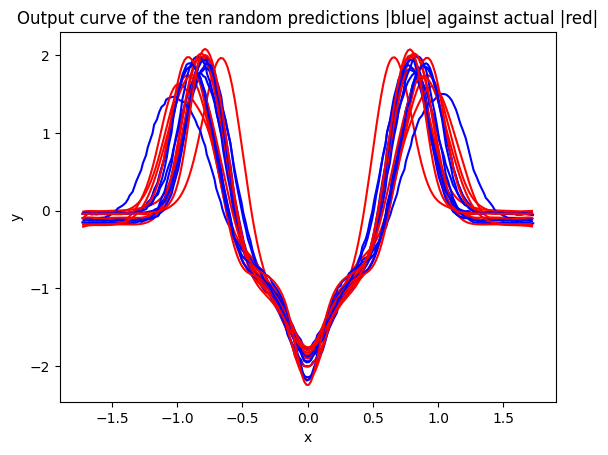

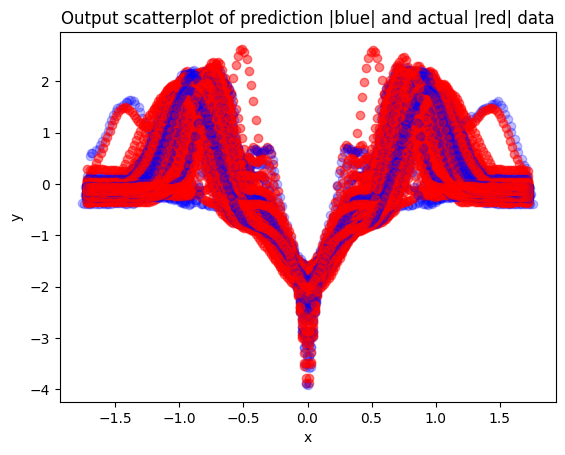

In [17]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_3_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=32, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

4/4 [==============================] - 0s 13ms/step


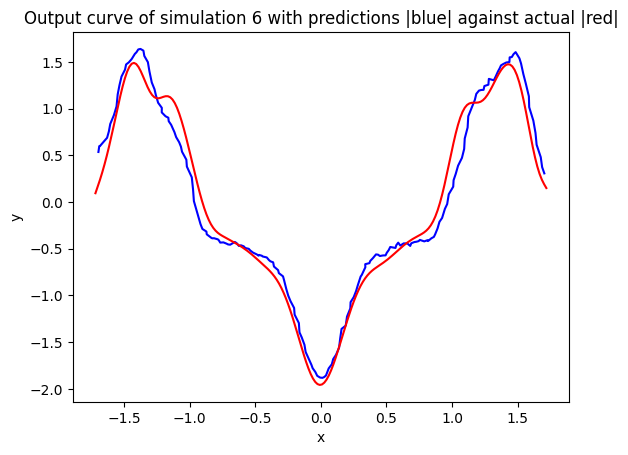

In [18]:
number = 6 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 15ms/step


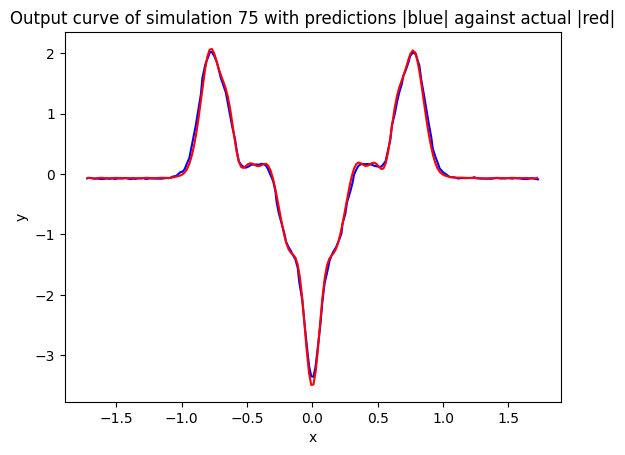

In [19]:
number = 75 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 11ms/step


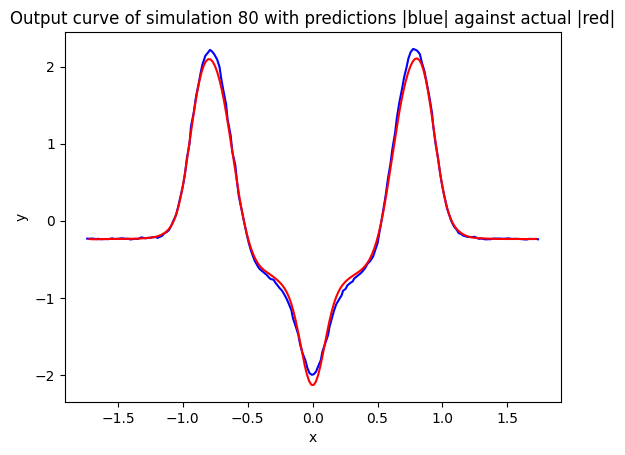

In [20]:
number = 80 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_28 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_21 (Dropout)        (None, 2000)              0         
                                                                 
 dense_29 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_22 (Dropout)        (None, 1000)              0         
                                                                 
 dense_30 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_23 (Dropout)        (None, 1000)              0   

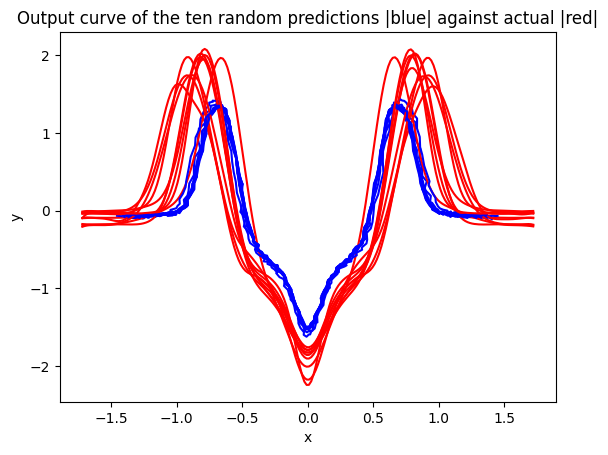

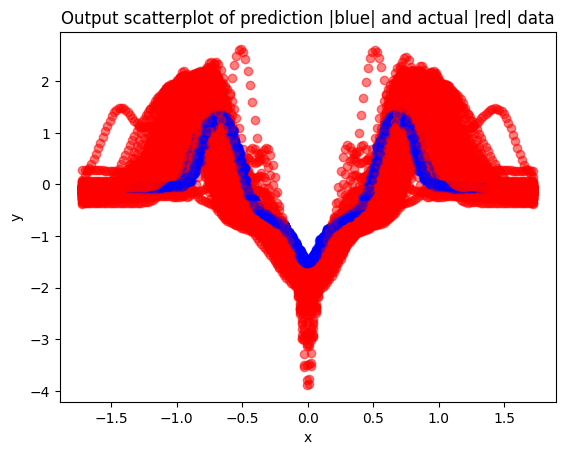

In [21]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=50),
             TensorBoard(log_dir='model_4_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=200, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_35 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_26 (Dropout)        (None, 2000)              0         
                                                                 
 dense_36 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_27 (Dropout)        (None, 1000)              0         
                                                                 
 dense_37 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_28 (Dropout)        (None, 1000)              0   

1/1 [==============================] - 0s 281ms/step - loss: 0.1488 - val_loss: 0.2149
Epoch 143/1500
1/1 [==============================] - 0s 274ms/step - loss: 0.1575 - val_loss: 0.2684
Epoch 144/1500
1/1 [==============================] - 0s 273ms/step - loss: 0.1575 - val_loss: 0.2320
Epoch 145/1500
1/1 [==============================] - 0s 290ms/step - loss: 0.1485 - val_loss: 0.2416
Epoch 146/1500
1/1 [==============================] - 0s 274ms/step - loss: 0.1466 - val_loss: 0.2569
Epoch 147/1500
1/1 [==============================] - 0s 274ms/step - loss: 0.1506 - val_loss: 0.2098
Epoch 148/1500
1/1 [==============================] - 0s 298ms/step - loss: 0.1655 - val_loss: 0.2726
Epoch 149/1500
1/1 [==============================] - 0s 297ms/step - loss: 0.1627 - val_loss: 0.2415
Epoch 150/1500
1/1 [==============================] - 0s 273ms/step - loss: 0.1450 - val_loss: 0.2038
Epoch 151/1500
1/1 [==============================] - 1s 1s/step - loss: 0.1691 - val_loss: 0.275

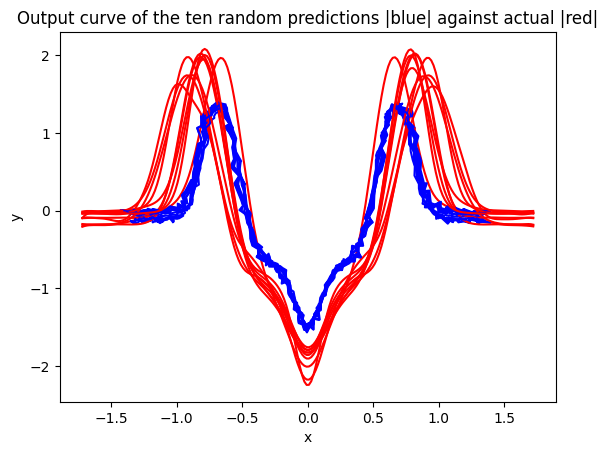

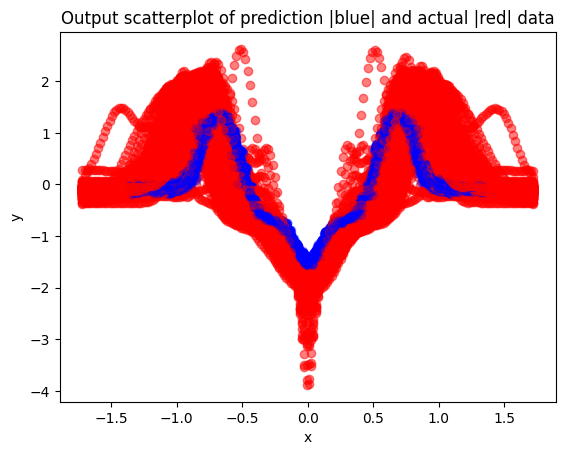

In [22]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_4_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=400, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_42 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_31 (Dropout)        (None, 2000)              0         
                                                                 
 dense_43 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_32 (Dropout)        (None, 1000)              0         
                                                                 
 dense_44 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_33 (Dropout)        (None, 1000)              0   

Epoch 60/1500
25/25 [==============================] - 3s 141ms/step - loss: 0.1014 - val_loss: 0.1239
Epoch 61/1500
25/25 [==============================] - 4s 154ms/step - loss: 0.1036 - val_loss: 0.1205
Epoch 62/1500
25/25 [==============================] - 3s 112ms/step - loss: 0.0995 - val_loss: 0.1281
Epoch 63/1500
25/25 [==============================] - 3s 107ms/step - loss: 0.1072 - val_loss: 0.1248
Epoch 64/1500
25/25 [==============================] - 3s 106ms/step - loss: 0.1028 - val_loss: 0.1264
Epoch 65/1500
25/25 [==============================] - 3s 113ms/step - loss: 0.1042 - val_loss: 0.1258
Epoch 66/1500
25/25 [==============================] - 3s 103ms/step - loss: 0.1046 - val_loss: 0.1206
Epoch 67/1500
25/25 [==============================] - 3s 103ms/step - loss: 0.1016 - val_loss: 0.1200
Epoch 68/1500
25/25 [==============================] - 3s 102ms/step - loss: 0.1015 - val_loss: 0.1246
Epoch 69/1500
25/25 [==============================] - 3s 103ms/step - lo

Epoch 218/1500
25/25 [==============================] - 3s 103ms/step - loss: 0.0802 - val_loss: 0.1023
Epoch 219/1500
25/25 [==============================] - 3s 103ms/step - loss: 0.0821 - val_loss: 0.1117
Epoch 220/1500
25/25 [==============================] - 3s 104ms/step - loss: 0.0804 - val_loss: 0.1069
Epoch 221/1500
25/25 [==============================] - 4s 155ms/step - loss: 0.0772 - val_loss: 0.0983
Epoch 222/1500
25/25 [==============================] - 3s 103ms/step - loss: 0.0802 - val_loss: 0.1060
Epoch 223/1500
25/25 [==============================] - 3s 103ms/step - loss: 0.0780 - val_loss: 0.1045
Epoch 224/1500
25/25 [==============================] - 3s 108ms/step - loss: 0.0855 - val_loss: 0.1042
Epoch 225/1500
25/25 [==============================] - 3s 105ms/step - loss: 0.0809 - val_loss: 0.1085
Epoch 226/1500
25/25 [==============================] - 3s 102ms/step - loss: 0.0789 - val_loss: 0.1035
Epoch 227/1500
25/25 [==============================] - 3s 102ms

Epoch 297/1500
25/25 [==============================] - 3s 101ms/step - loss: 0.0809 - val_loss: 0.1056
Epoch 298/1500
25/25 [==============================] - 3s 102ms/step - loss: 0.0767 - val_loss: 0.1052
Epoch 299/1500
25/25 [==============================] - 3s 101ms/step - loss: 0.0759 - val_loss: 0.1034
Epoch 300/1500
25/25 [==============================] - 3s 103ms/step - loss: 0.0735 - val_loss: 0.1035
Epoch 301/1500
25/25 [==============================] - 4s 149ms/step - loss: 0.0746 - val_loss: 0.0991
Epoch 302/1500
25/25 [==============================] - 3s 103ms/step - loss: 0.0765 - val_loss: 0.1023
Epoch 303/1500
25/25 [==============================] - 3s 102ms/step - loss: 0.0768 - val_loss: 0.1005
Epoch 304/1500
25/25 [==============================] - 3s 103ms/step - loss: 0.0735 - val_loss: 0.1035
Epoch 305/1500
25/25 [==============================] - 3s 102ms/step - loss: 0.0741 - val_loss: 0.1053
Epoch 306/1500
25/25 [==============================] - 3s 101ms

Epoch 376/1500
25/25 [==============================] - 2s 100ms/step - loss: 0.0691 - val_loss: 0.1001
Epoch 377/1500
25/25 [==============================] - 3s 104ms/step - loss: 0.0711 - val_loss: 0.1031
Epoch 378/1500
25/25 [==============================] - 3s 102ms/step - loss: 0.0710 - val_loss: 0.1063
Epoch 379/1500
25/25 [==============================] - 3s 103ms/step - loss: 0.0709 - val_loss: 0.1000
Epoch 380/1500
25/25 [==============================] - 3s 107ms/step - loss: 0.0736 - val_loss: 0.1026
Epoch 381/1500
25/25 [==============================] - 4s 165ms/step - loss: 0.0657 - val_loss: 0.1028
Epoch 382/1500
25/25 [==============================] - 3s 106ms/step - loss: 0.0707 - val_loss: 0.1047
Epoch 383/1500
25/25 [==============================] - 3s 101ms/step - loss: 0.0682 - val_loss: 0.1041
Epoch 384/1500
25/25 [==============================] - 3s 105ms/step - loss: 0.0696 - val_loss: 0.1038
Epoch 385/1500
25/25 [==============================] - 3s 104ms

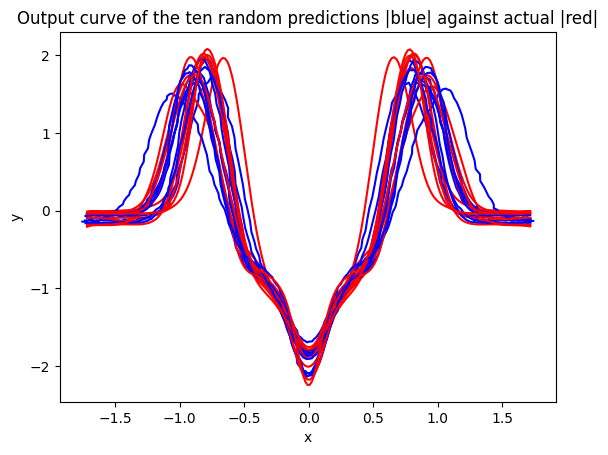

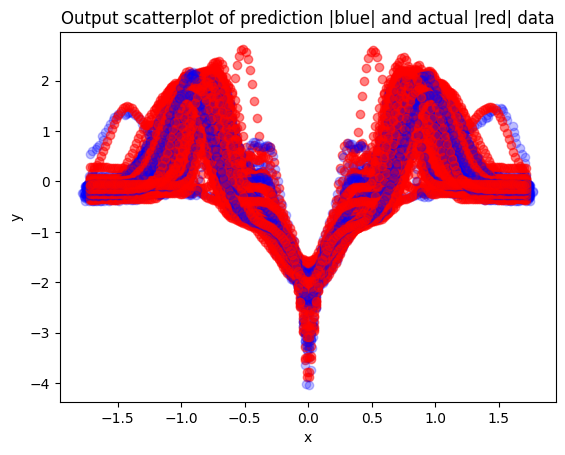

In [23]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_3_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=16, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

4/4 [==============================] - 0s 11ms/step


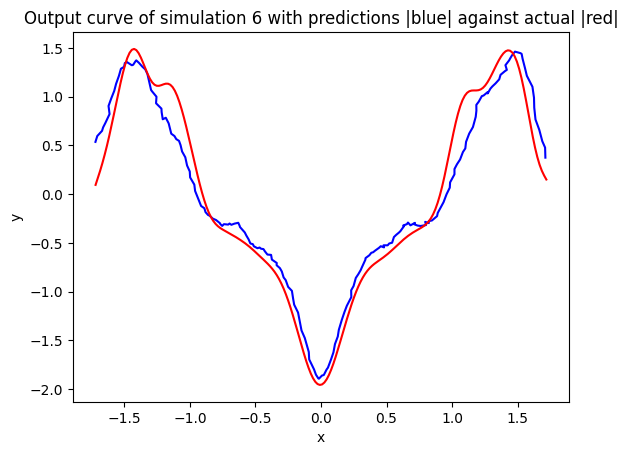

In [24]:
number = 6 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 10ms/step


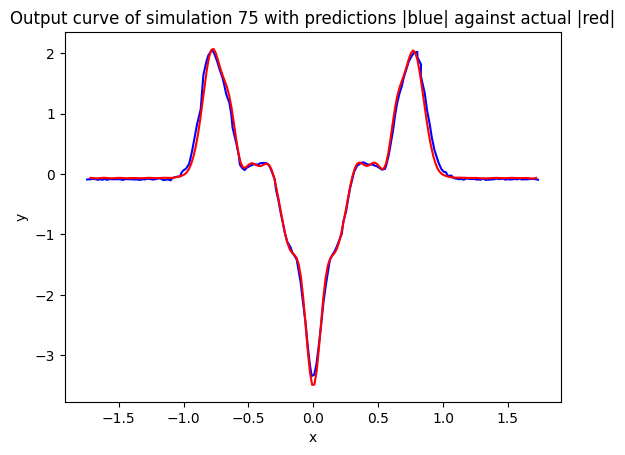

In [25]:
number = 75 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 10ms/step


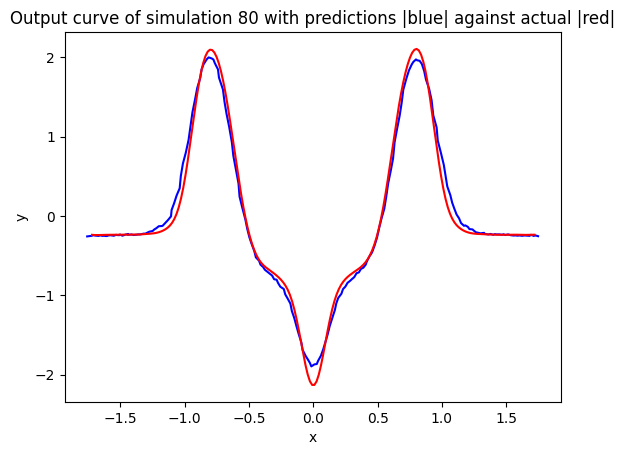

In [26]:
number = 80 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_49 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_36 (Dropout)        (None, 2000)              0         
                                                                 
 dense_50 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_37 (Dropout)        (None, 1000)              0         
                                                                 
 dense_51 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_38 (Dropout)        (None, 1000)              0   

4/4 [==============================] - 2s 574ms/step - loss: 0.1630 - val_loss: 0.1936
Epoch 62/1500
4/4 [==============================] - 1s 143ms/step - loss: 0.1580 - val_loss: 0.1474
Epoch 63/1500
4/4 [==============================] - 1s 148ms/step - loss: 0.1574 - val_loss: 0.1526
Epoch 64/1500
4/4 [==============================] - 1s 143ms/step - loss: 0.1545 - val_loss: 0.1598
Epoch 65/1500
4/4 [==============================] - 1s 146ms/step - loss: 0.1555 - val_loss: 0.1637
Epoch 66/1500
4/4 [==============================] - 1s 151ms/step - loss: 0.1517 - val_loss: 0.2043
Epoch 67/1500
4/4 [==============================] - 1s 204ms/step - loss: 0.1673 - val_loss: 0.1967
Epoch 68/1500
4/4 [==============================] - 1s 223ms/step - loss: 0.1573 - val_loss: 0.1948
Epoch 69/1500
4/4 [==============================] - 1s 280ms/step - loss: 0.1559 - val_loss: 0.1829
Epoch 70/1500
4/4 [==============================] - 1s 137ms/step - loss: 0.1528 - val_loss: 0.1984
Epoc

Epoch 142/1500
4/4 [==============================] - 1s 163ms/step - loss: 0.1237 - val_loss: 0.1361
Epoch 143/1500
4/4 [==============================] - 1s 165ms/step - loss: 0.1211 - val_loss: 0.1387
Epoch 144/1500
4/4 [==============================] - 1s 145ms/step - loss: 0.1206 - val_loss: 0.1347
Epoch 145/1500
4/4 [==============================] - 1s 152ms/step - loss: 0.1181 - val_loss: 0.1391
Epoch 146/1500
4/4 [==============================] - 1s 152ms/step - loss: 0.1196 - val_loss: 0.1360
Epoch 147/1500
4/4 [==============================] - 1s 142ms/step - loss: 0.1195 - val_loss: 0.1448
Epoch 148/1500
4/4 [==============================] - 1s 150ms/step - loss: 0.1207 - val_loss: 0.1392
Epoch 149/1500
4/4 [==============================] - 1s 140ms/step - loss: 0.1190 - val_loss: 0.1410
Epoch 150/1500
4/4 [==============================] - 1s 146ms/step - loss: 0.1212 - val_loss: 0.1459
Epoch 151/1500
4/4 [==============================] - 2s 571ms/step - loss: 0.1255

4/4 [==============================] - 1s 138ms/step - loss: 0.1018 - val_loss: 0.1300
Epoch 303/1500
4/4 [==============================] - 1s 143ms/step - loss: 0.0996 - val_loss: 0.1206
Epoch 304/1500
4/4 [==============================] - 1s 139ms/step - loss: 0.0985 - val_loss: 0.1206
Epoch 305/1500
4/4 [==============================] - 1s 138ms/step - loss: 0.0976 - val_loss: 0.1204
Epoch 306/1500
4/4 [==============================] - 1s 150ms/step - loss: 0.0977 - val_loss: 0.1228
Epoch 307/1500
4/4 [==============================] - 1s 140ms/step - loss: 0.1007 - val_loss: 0.1275
Epoch 308/1500
4/4 [==============================] - 1s 148ms/step - loss: 0.1043 - val_loss: 0.1287
Epoch 309/1500
4/4 [==============================] - 1s 152ms/step - loss: 0.1065 - val_loss: 0.1223
Epoch 310/1500
4/4 [==============================] - 1s 148ms/step - loss: 0.1024 - val_loss: 0.1221
Epoch 311/1500
4/4 [==============================] - 2s 554ms/step - loss: 0.0996 - val_loss: 0.

4/4 [==============================] - 1s 141ms/step - loss: 0.0929 - val_loss: 0.1183
Epoch 463/1500
4/4 [==============================] - 1s 200ms/step - loss: 0.0955 - val_loss: 0.1197
Epoch 464/1500
4/4 [==============================] - 1s 142ms/step - loss: 0.0961 - val_loss: 0.1167
Epoch 465/1500
4/4 [==============================] - 1s 143ms/step - loss: 0.0956 - val_loss: 0.1193
Epoch 466/1500
4/4 [==============================] - 1s 144ms/step - loss: 0.0944 - val_loss: 0.1188
Epoch 467/1500
4/4 [==============================] - 1s 144ms/step - loss: 0.0946 - val_loss: 0.1209
Epoch 468/1500
4/4 [==============================] - 1s 138ms/step - loss: 0.0967 - val_loss: 0.1188
Epoch 469/1500
4/4 [==============================] - 1s 146ms/step - loss: 0.0945 - val_loss: 0.1250
Epoch 470/1500
4/4 [==============================] - 1s 133ms/step - loss: 0.0943 - val_loss: 0.1202
Epoch 471/1500
4/4 [==============================] - 2s 574ms/step - loss: 0.0933 - val_loss: 0.

4/4 [==============================] - 1s 143ms/step - loss: 0.0892 - val_loss: 0.1101
Epoch 623/1500
4/4 [==============================] - 1s 144ms/step - loss: 0.0878 - val_loss: 0.1141
Epoch 624/1500
4/4 [==============================] - 1s 140ms/step - loss: 0.0911 - val_loss: 0.1106
Epoch 625/1500
4/4 [==============================] - 1s 143ms/step - loss: 0.0921 - val_loss: 0.1142
Epoch 626/1500
4/4 [==============================] - 1s 154ms/step - loss: 0.0972 - val_loss: 0.1098
Epoch 627/1500
4/4 [==============================] - 1s 139ms/step - loss: 0.0927 - val_loss: 0.1122
Epoch 628/1500
4/4 [==============================] - 1s 142ms/step - loss: 0.0916 - val_loss: 0.1114
Epoch 629/1500
4/4 [==============================] - 1s 140ms/step - loss: 0.0883 - val_loss: 0.1092
Epoch 630/1500
4/4 [==============================] - 1s 151ms/step - loss: 0.0887 - val_loss: 0.1122
Epoch 631/1500
4/4 [==============================] - 2s 757ms/step - loss: 0.0884 - val_loss: 0.

4/4 [==============================] - 5s 1s/step - loss: 0.0844 - val_loss: 0.1065
Epoch 783/1500
4/4 [==============================] - 3s 1s/step - loss: 0.0868 - val_loss: 0.1053
Epoch 784/1500
4/4 [==============================] - 2s 614ms/step - loss: 0.0846 - val_loss: 0.1078
Epoch 785/1500
4/4 [==============================] - 1s 149ms/step - loss: 0.0813 - val_loss: 0.1048
Epoch 786/1500
4/4 [==============================] - 1s 151ms/step - loss: 0.0827 - val_loss: 0.1029
Epoch 787/1500
4/4 [==============================] - 2s 538ms/step - loss: 0.0815 - val_loss: 0.1017
Epoch 788/1500
4/4 [==============================] - 2s 511ms/step - loss: 0.0836 - val_loss: 0.1049
Epoch 789/1500
4/4 [==============================] - 2s 642ms/step - loss: 0.0808 - val_loss: 0.1046
Epoch 790/1500
4/4 [==============================] - 1s 442ms/step - loss: 0.0821 - val_loss: 0.1019
Epoch 791/1500
4/4 [==============================] - 3s 1s/step - loss: 0.0823 - val_loss: 0.0996
Epoc

4/4 [==============================] - 1s 153ms/step - loss: 0.0791 - val_loss: 0.1036
Epoch 943/1500
4/4 [==============================] - 1s 136ms/step - loss: 0.0792 - val_loss: 0.1022
Epoch 944/1500
4/4 [==============================] - 1s 137ms/step - loss: 0.0796 - val_loss: 0.1030
Epoch 945/1500
4/4 [==============================] - 1s 137ms/step - loss: 0.0796 - val_loss: 0.1034
Epoch 946/1500
4/4 [==============================] - 1s 144ms/step - loss: 0.0767 - val_loss: 0.1028
Epoch 947/1500
4/4 [==============================] - 1s 139ms/step - loss: 0.0787 - val_loss: 0.1012
Epoch 948/1500
4/4 [==============================] - 1s 137ms/step - loss: 0.0820 - val_loss: 0.1029
Epoch 949/1500
4/4 [==============================] - 1s 137ms/step - loss: 0.0844 - val_loss: 0.1015
Epoch 950/1500
4/4 [==============================] - 1s 145ms/step - loss: 0.0788 - val_loss: 0.1023
Epoch 951/1500
4/4 [==============================] - 2s 554ms/step - loss: 0.0795 - val_loss: 0.

4/4 [==============================] - 2s 497ms/step - loss: 0.0806 - val_loss: 0.1065
Epoch 1102/1500
4/4 [==============================] - 1s 134ms/step - loss: 0.0833 - val_loss: 0.1065
Epoch 1103/1500
4/4 [==============================] - 1s 147ms/step - loss: 0.0797 - val_loss: 0.1092
Epoch 1104/1500
4/4 [==============================] - 1s 141ms/step - loss: 0.0795 - val_loss: 0.1090
Epoch 1105/1500
4/4 [==============================] - 1s 134ms/step - loss: 0.0825 - val_loss: 0.1072
Epoch 1106/1500
4/4 [==============================] - 1s 447ms/step - loss: 0.0820 - val_loss: 0.1051
Epoch 1107/1500
4/4 [==============================] - 1s 140ms/step - loss: 0.0791 - val_loss: 0.1040
Epoch 1108/1500
4/4 [==============================] - 1s 146ms/step - loss: 0.0763 - val_loss: 0.1019
Epoch 1109/1500
4/4 [==============================] - 1s 138ms/step - loss: 0.0765 - val_loss: 0.1013
Epoch 1110/1500
4/4 [==============================] - 1s 139ms/step - loss: 0.0738 - val

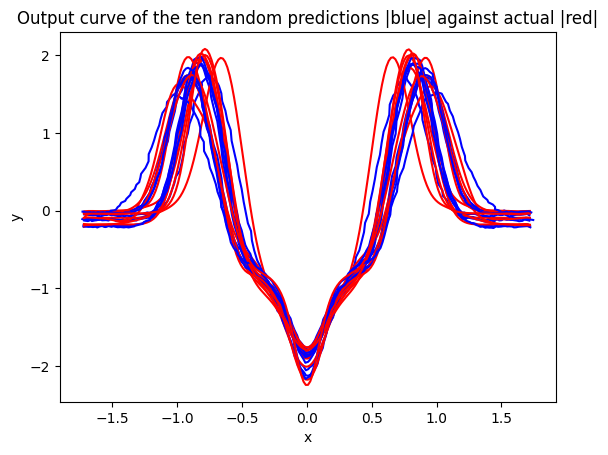

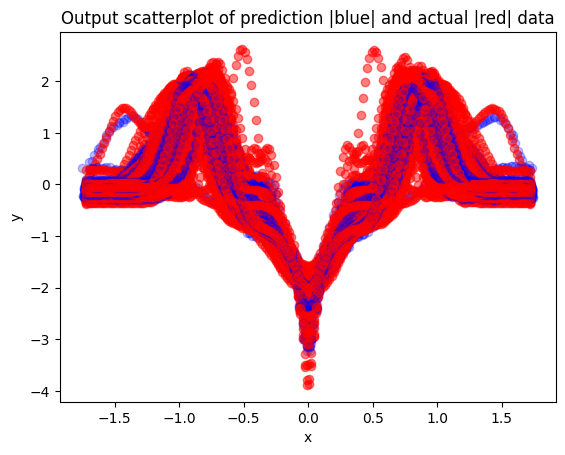

In [27]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_3_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=128, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

4/4 [==============================] - 0s 12ms/step


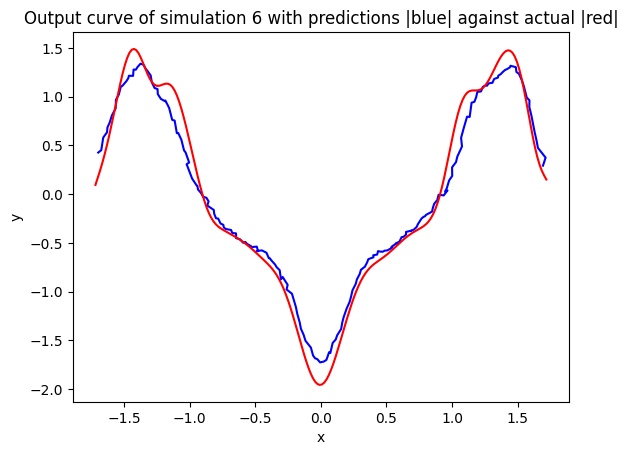

In [28]:
number = 6 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 11ms/step


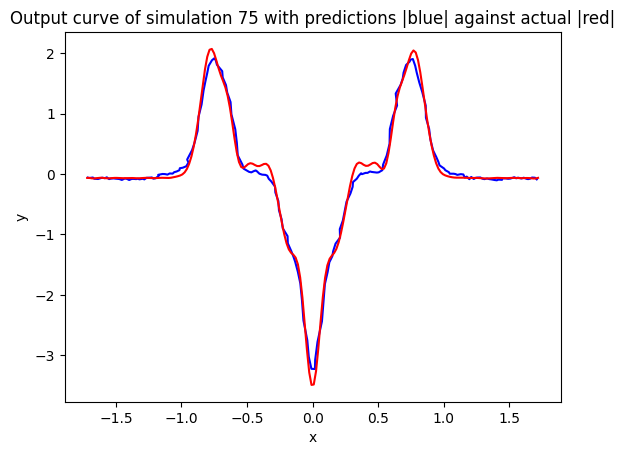

In [29]:
number = 75 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 12ms/step


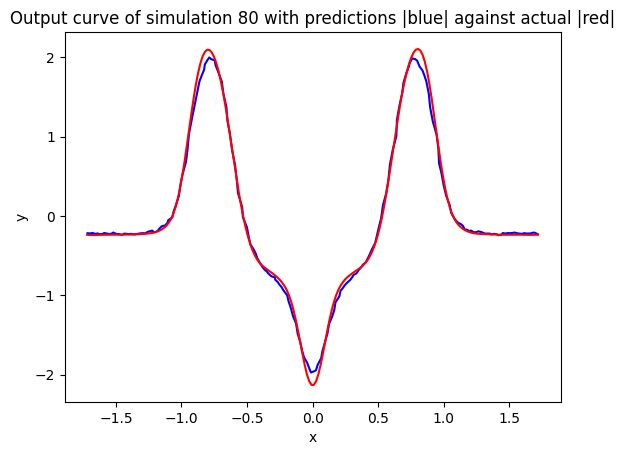

In [30]:
number = 80 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_56 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_41 (Dropout)        (None, 2000)              0         
                                                                 
 dense_57 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_42 (Dropout)        (None, 1000)              0         
                                                                 
 dense_58 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_43 (Dropout)        (None, 1000)              0   

7/7 [==============================] - 2s 304ms/step - loss: 0.1184 - val_loss: 0.1310
Epoch 62/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.1177 - val_loss: 0.1326
Epoch 63/1500
7/7 [==============================] - 1s 117ms/step - loss: 0.1173 - val_loss: 0.1399
Epoch 64/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.1155 - val_loss: 0.1291
Epoch 65/1500
7/7 [==============================] - 1s 127ms/step - loss: 0.1136 - val_loss: 0.1326
Epoch 66/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.1148 - val_loss: 0.1350
Epoch 67/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.1113 - val_loss: 0.1306
Epoch 68/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.1118 - val_loss: 0.1344
Epoch 69/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.1091 - val_loss: 0.1286
Epoch 70/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1086 - val_loss: 0.1260
Epoc

Epoch 142/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0888 - val_loss: 0.1075
Epoch 143/1500
7/7 [==============================] - 1s 148ms/step - loss: 0.0905 - val_loss: 0.1104
Epoch 144/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0910 - val_loss: 0.1037
Epoch 145/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0906 - val_loss: 0.1060
Epoch 146/1500
7/7 [==============================] - 1s 117ms/step - loss: 0.0906 - val_loss: 0.1093
Epoch 147/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0862 - val_loss: 0.1032
Epoch 148/1500
7/7 [==============================] - 1s 117ms/step - loss: 0.0885 - val_loss: 0.1165
Epoch 149/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0920 - val_loss: 0.1158
Epoch 150/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0911 - val_loss: 0.1109
Epoch 151/1500
7/7 [==============================] - 2s 326ms/step - loss: 0.0891

7/7 [==============================] - 1s 124ms/step - loss: 0.0679 - val_loss: 0.1030
Epoch 303/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0671 - val_loss: 0.1028
Epoch 304/1500
7/7 [==============================] - 1s 117ms/step - loss: 0.0678 - val_loss: 0.0999
Epoch 305/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0649 - val_loss: 0.0961
Epoch 306/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0686 - val_loss: 0.0969
Epoch 307/1500
7/7 [==============================] - 1s 134ms/step - loss: 0.0652 - val_loss: 0.0992
Epoch 308/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0677 - val_loss: 0.1020
Epoch 309/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0685 - val_loss: 0.1008
Epoch 310/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0636 - val_loss: 0.0972
Epoch 311/1500
7/7 [==============================] - 2s 307ms/step - loss: 0.0615 - val_loss: 0.

7/7 [==============================] - 1s 120ms/step - loss: 0.0498 - val_loss: 0.0962
Epoch 463/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0492 - val_loss: 0.0980
Epoch 464/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0521 - val_loss: 0.0975
Epoch 465/1500
7/7 [==============================] - 1s 127ms/step - loss: 0.0509 - val_loss: 0.0952
Epoch 466/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0475 - val_loss: 0.1032
Epoch 467/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0522 - val_loss: 0.0994
Epoch 468/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0541 - val_loss: 0.1070
Epoch 469/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0515 - val_loss: 0.0943
Epoch 470/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0483 - val_loss: 0.1010
Epoch 471/1500
7/7 [==============================] - 2s 313ms/step - loss: 0.0498 - val_loss: 0.

7/7 [==============================] - 1s 127ms/step - loss: 0.0376 - val_loss: 0.0975
Epoch 623/1500
7/7 [==============================] - 1s 125ms/step - loss: 0.0374 - val_loss: 0.0953
Epoch 624/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0349 - val_loss: 0.0960
Epoch 625/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0400 - val_loss: 0.0998
Epoch 626/1500
7/7 [==============================] - 1s 129ms/step - loss: 0.0393 - val_loss: 0.0960
Epoch 627/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0394 - val_loss: 0.1028
Epoch 628/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0367 - val_loss: 0.1086
Epoch 629/1500
7/7 [==============================] - 1s 130ms/step - loss: 0.0435 - val_loss: 0.1012
Epoch 630/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0423 - val_loss: 0.0960
Epoch 631/1500
7/7 [==============================] - 2s 303ms/step - loss: 0.0407 - val_loss: 0.

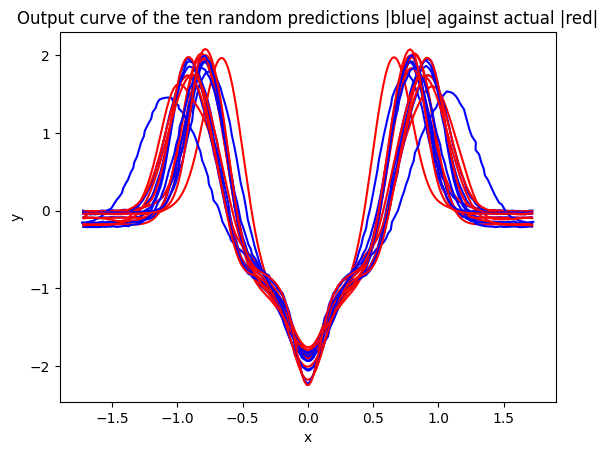

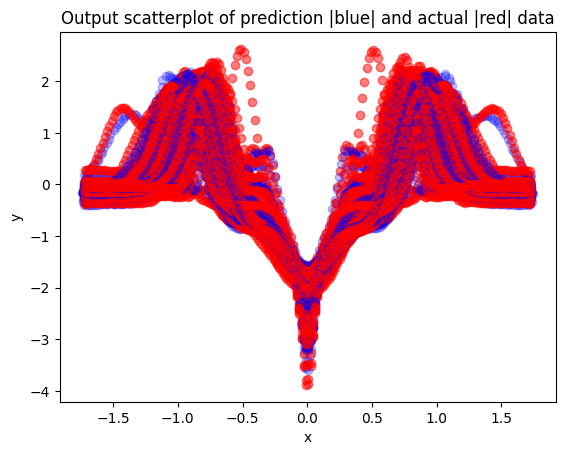

In [31]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_4_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

4/4 [==============================] - 0s 12ms/step


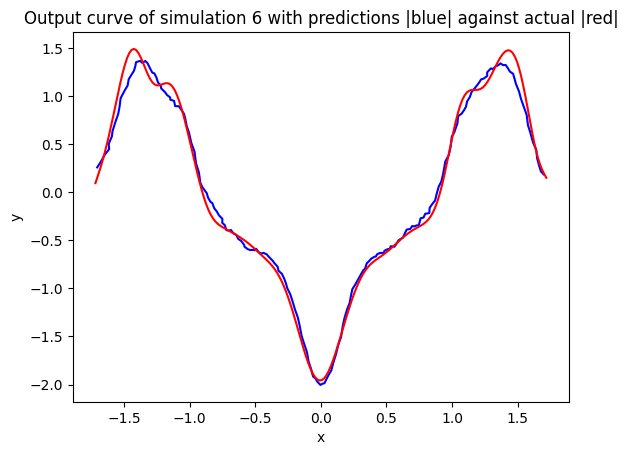

In [32]:
number = 6 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 11ms/step


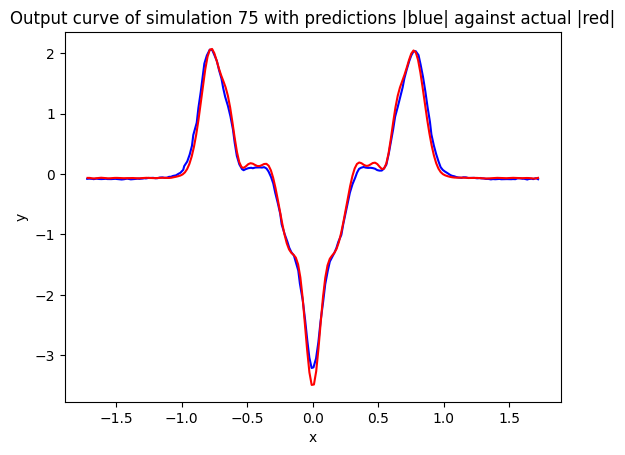

In [33]:
number = 75 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 12ms/step


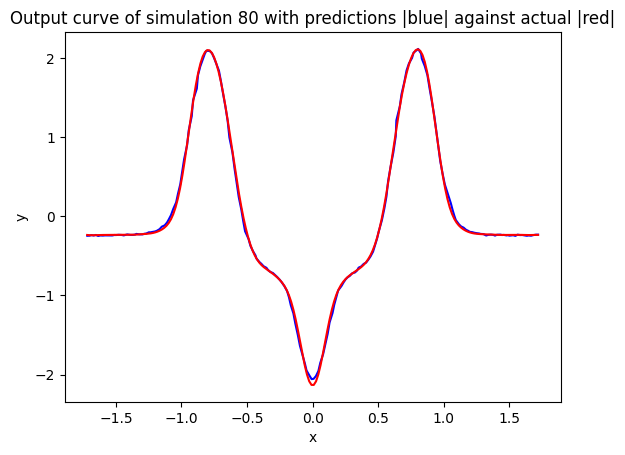

In [34]:
number = 80 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_63 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_46 (Dropout)        (None, 2000)              0         
                                                                 
 dense_64 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_47 (Dropout)        (None, 1000)              0         
                                                                 
 dense_65 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_48 (Dropout)        (None, 1000)              0   

Epoch 56/1500
7/7 [==============================] - 1s 162ms/step - loss: 0.1381 - val_loss: 0.1433
Epoch 57/1500
7/7 [==============================] - 1s 163ms/step - loss: 0.1378 - val_loss: 0.1461
Epoch 58/1500
7/7 [==============================] - 1s 148ms/step - loss: 0.1378 - val_loss: 0.1447
Epoch 59/1500
7/7 [==============================] - 1s 152ms/step - loss: 0.1373 - val_loss: 0.1462
Epoch 60/1500
7/7 [==============================] - 1s 151ms/step - loss: 0.1370 - val_loss: 0.1482
Epoch 61/1500
7/7 [==============================] - 2s 395ms/step - loss: 0.1372 - val_loss: 0.1483
Epoch 62/1500
7/7 [==============================] - 1s 191ms/step - loss: 0.1373 - val_loss: 0.1451
Epoch 63/1500
7/7 [==============================] - 1s 148ms/step - loss: 0.1370 - val_loss: 0.1477
Epoch 64/1500
7/7 [==============================] - 1s 147ms/step - loss: 0.1365 - val_loss: 0.1431
Epoch 65/1500
7/7 [==============================] - 1s 153ms/step - loss: 0.1368 - val_los

Epoch 137/1500
7/7 [==============================] - 1s 147ms/step - loss: 0.1138 - val_loss: 0.1335
Epoch 138/1500
7/7 [==============================] - 1s 150ms/step - loss: 0.1105 - val_loss: 0.1283
Epoch 139/1500
7/7 [==============================] - 1s 149ms/step - loss: 0.1094 - val_loss: 0.1346
Epoch 140/1500
7/7 [==============================] - 1s 147ms/step - loss: 0.1101 - val_loss: 0.1324
Epoch 141/1500
7/7 [==============================] - 2s 394ms/step - loss: 0.1086 - val_loss: 0.1294
Epoch 142/1500
7/7 [==============================] - 1s 162ms/step - loss: 0.1092 - val_loss: 0.1331
Epoch 143/1500
7/7 [==============================] - 1s 145ms/step - loss: 0.1100 - val_loss: 0.1303
Epoch 144/1500
7/7 [==============================] - 1s 149ms/step - loss: 0.1078 - val_loss: 0.1325
Epoch 145/1500
7/7 [==============================] - 1s 150ms/step - loss: 0.1121 - val_loss: 0.1312
Epoch 146/1500
7/7 [==============================] - 1s 148ms/step - loss: 0.1086

7/7 [==============================] - 1s 149ms/step - loss: 0.0837 - val_loss: 0.1121
Epoch 298/1500
7/7 [==============================] - 1s 148ms/step - loss: 0.0815 - val_loss: 0.1047
Epoch 299/1500
7/7 [==============================] - 1s 202ms/step - loss: 0.0787 - val_loss: 0.1099
Epoch 300/1500
7/7 [==============================] - 2s 270ms/step - loss: 0.0813 - val_loss: 0.1044
Epoch 301/1500
7/7 [==============================] - 3s 416ms/step - loss: 0.0808 - val_loss: 0.1053
Epoch 302/1500
7/7 [==============================] - 1s 151ms/step - loss: 0.0790 - val_loss: 0.1120
Epoch 303/1500
7/7 [==============================] - 1s 155ms/step - loss: 0.0841 - val_loss: 0.1124
Epoch 304/1500
7/7 [==============================] - 1s 181ms/step - loss: 0.0785 - val_loss: 0.1113
Epoch 305/1500
7/7 [==============================] - 1s 148ms/step - loss: 0.0772 - val_loss: 0.1066
Epoch 306/1500
7/7 [==============================] - 1s 158ms/step - loss: 0.0757 - val_loss: 0.

7/7 [==============================] - 1s 154ms/step - loss: 0.0605 - val_loss: 0.0998
Epoch 458/1500
7/7 [==============================] - 1s 188ms/step - loss: 0.0629 - val_loss: 0.1030
Epoch 459/1500
7/7 [==============================] - 1s 192ms/step - loss: 0.0633 - val_loss: 0.0973
Epoch 460/1500
7/7 [==============================] - 1s 194ms/step - loss: 0.0631 - val_loss: 0.0952
Epoch 461/1500
7/7 [==============================] - 3s 438ms/step - loss: 0.0602 - val_loss: 0.1010
Epoch 462/1500
7/7 [==============================] - 1s 172ms/step - loss: 0.0607 - val_loss: 0.1005
Epoch 463/1500
7/7 [==============================] - 1s 155ms/step - loss: 0.0610 - val_loss: 0.1035
Epoch 464/1500
7/7 [==============================] - 1s 157ms/step - loss: 0.0617 - val_loss: 0.1025
Epoch 465/1500
7/7 [==============================] - 1s 161ms/step - loss: 0.0586 - val_loss: 0.1008
Epoch 466/1500
7/7 [==============================] - 1s 161ms/step - loss: 0.0611 - val_loss: 0.

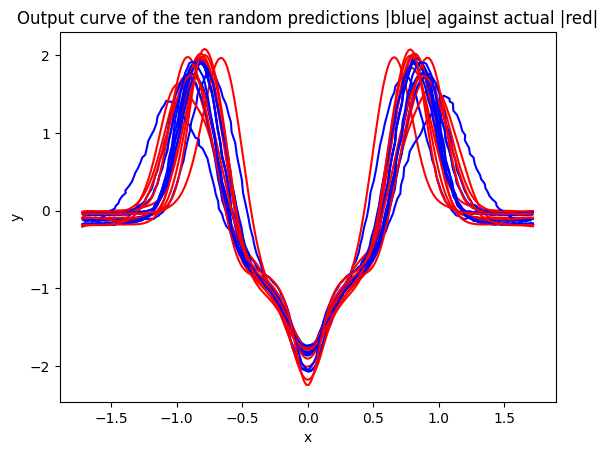

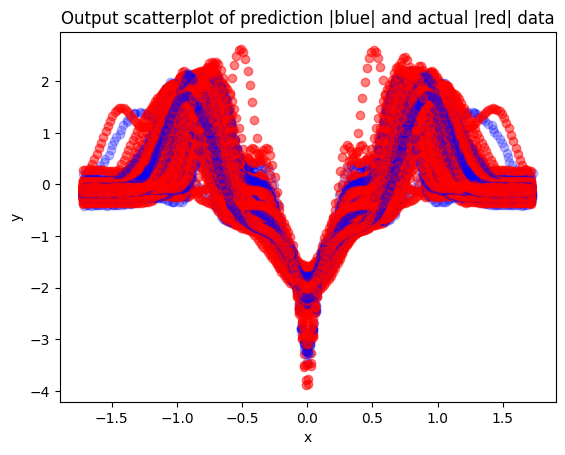

In [35]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_4_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

4/4 [==============================] - 0s 15ms/step


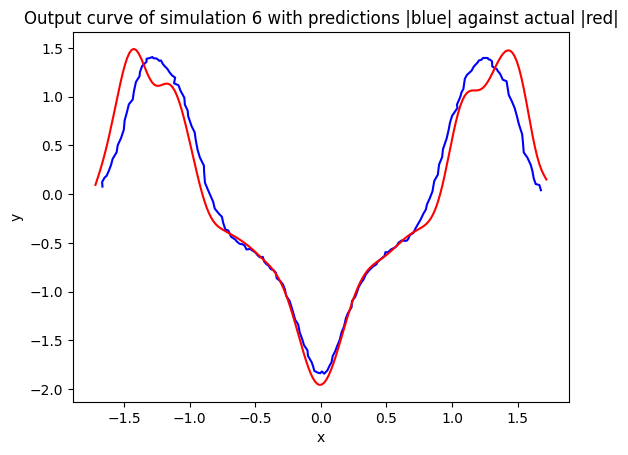

In [36]:
number = 6 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 15ms/step


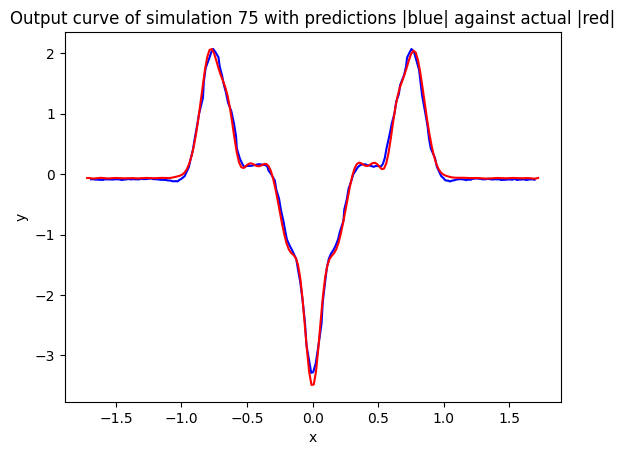

In [37]:
number = 75 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

4/4 [==============================] - 0s 13ms/step


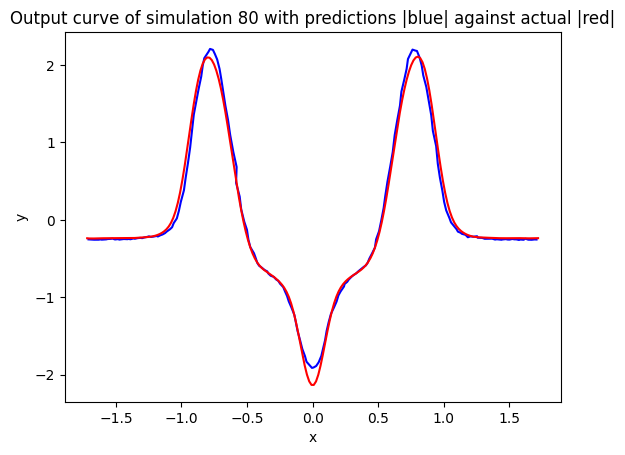

In [38]:
number = 80 # Number six is broken
prediction = model.predict(test_input_values)
length = int(len(prediction[0])/2)
x_1 = prediction[number][0:length]
y_1 = prediction[number][length:]
plt.plot(x_1,y_1,c='b')

x_2 = test_output_values[number][0:length]
y_2 = test_output_values[number][length:]
plt.plot(x_2,y_2,c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
plt.show() 

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_72 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_53 (Dropout)        (None, 2000)              0         
                                                                 
 dense_73 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_54 (Dropout)        (None, 1000)              0         
                                                                 
 dense_74 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_55 (Dropout)        (None, 1000)              0  

Epoch 56/1500
7/7 [==============================] - 1s 147ms/step - loss: 0.1363 - val_loss: 0.1421
Epoch 57/1500
7/7 [==============================] - 1s 146ms/step - loss: 0.1374 - val_loss: 0.1504
Epoch 58/1500
7/7 [==============================] - 1s 143ms/step - loss: 0.1391 - val_loss: 0.1474
Epoch 59/1500
7/7 [==============================] - 1s 148ms/step - loss: 0.1386 - val_loss: 0.1495
Epoch 60/1500
7/7 [==============================] - 1s 148ms/step - loss: 0.1373 - val_loss: 0.1438
Epoch 61/1500
7/7 [==============================] - 2s 393ms/step - loss: 0.1365 - val_loss: 0.1493
Epoch 62/1500
7/7 [==============================] - 1s 172ms/step - loss: 0.1376 - val_loss: 0.1434
Epoch 63/1500
7/7 [==============================] - 1s 150ms/step - loss: 0.1371 - val_loss: 0.1469
Epoch 64/1500
7/7 [==============================] - 1s 149ms/step - loss: 0.1372 - val_loss: 0.1464
Epoch 65/1500
7/7 [==============================] - 1s 150ms/step - loss: 0.1363 - val_los

Epoch 137/1500
7/7 [==============================] - 1s 147ms/step - loss: 0.1070 - val_loss: 0.1287
Epoch 138/1500
7/7 [==============================] - 1s 149ms/step - loss: 0.1062 - val_loss: 0.1289
Epoch 139/1500
7/7 [==============================] - 1s 150ms/step - loss: 0.1066 - val_loss: 0.1359
Epoch 140/1500
7/7 [==============================] - 1s 150ms/step - loss: 0.1076 - val_loss: 0.1336
Epoch 141/1500
7/7 [==============================] - 2s 378ms/step - loss: 0.1060 - val_loss: 0.1282
Epoch 142/1500
7/7 [==============================] - 1s 164ms/step - loss: 0.1058 - val_loss: 0.1300
Epoch 143/1500
7/7 [==============================] - 1s 149ms/step - loss: 0.1061 - val_loss: 0.1265
Epoch 144/1500
7/7 [==============================] - 1s 147ms/step - loss: 0.1062 - val_loss: 0.1326
Epoch 145/1500
7/7 [==============================] - 1s 147ms/step - loss: 0.1081 - val_loss: 0.1325
Epoch 146/1500
7/7 [==============================] - 1s 146ms/step - loss: 0.1083

7/7 [==============================] - 1s 202ms/step - loss: 0.0819 - val_loss: 0.1066
Epoch 298/1500
7/7 [==============================] - 1s 171ms/step - loss: 0.0810 - val_loss: 0.1078
Epoch 299/1500
7/7 [==============================] - 1s 170ms/step - loss: 0.0854 - val_loss: 0.1029
Epoch 300/1500
7/7 [==============================] - 1s 201ms/step - loss: 0.0854 - val_loss: 0.1107
Epoch 301/1500
7/7 [==============================] - 3s 493ms/step - loss: 0.0798 - val_loss: 0.1044
Epoch 302/1500
7/7 [==============================] - 1s 213ms/step - loss: 0.0820 - val_loss: 0.1043
Epoch 303/1500
7/7 [==============================] - 1s 207ms/step - loss: 0.0774 - val_loss: 0.1032
Epoch 304/1500
7/7 [==============================] - 1s 187ms/step - loss: 0.0801 - val_loss: 0.1035
Epoch 305/1500
7/7 [==============================] - 1s 171ms/step - loss: 0.0790 - val_loss: 0.1061
Epoch 306/1500
7/7 [==============================] - 1s 161ms/step - loss: 0.0777 - val_loss: 0.

7/7 [==============================] - 1s 145ms/step - loss: 0.0627 - val_loss: 0.1053
Epoch 458/1500
7/7 [==============================] - 1s 145ms/step - loss: 0.0614 - val_loss: 0.1016
Epoch 459/1500
7/7 [==============================] - 1s 147ms/step - loss: 0.0635 - val_loss: 0.0971
Epoch 460/1500
7/7 [==============================] - 1s 144ms/step - loss: 0.0607 - val_loss: 0.0986
Epoch 461/1500
7/7 [==============================] - 2s 392ms/step - loss: 0.0613 - val_loss: 0.0970
Epoch 462/1500
7/7 [==============================] - 1s 147ms/step - loss: 0.0626 - val_loss: 0.1012
Epoch 463/1500
7/7 [==============================] - 1s 143ms/step - loss: 0.0605 - val_loss: 0.1015
Epoch 464/1500
7/7 [==============================] - 1s 144ms/step - loss: 0.0625 - val_loss: 0.1001
Epoch 465/1500
7/7 [==============================] - 1s 142ms/step - loss: 0.0694 - val_loss: 0.1105
Epoch 466/1500
7/7 [==============================] - 1s 144ms/step - loss: 0.0696 - val_loss: 0.

7/7 [==============================] - 1s 158ms/step - loss: 0.0548 - val_loss: 0.1005
Epoch 618/1500
7/7 [==============================] - 1s 162ms/step - loss: 0.0512 - val_loss: 0.1026
Epoch 619/1500
7/7 [==============================] - 2s 254ms/step - loss: 0.0522 - val_loss: 0.1008
Epoch 620/1500
7/7 [==============================] - 1s 144ms/step - loss: 0.0531 - val_loss: 0.1064
Epoch 621/1500
7/7 [==============================] - 3s 440ms/step - loss: 0.0560 - val_loss: 0.1093
Epoch 622/1500
7/7 [==============================] - 1s 147ms/step - loss: 0.0562 - val_loss: 0.1091
Epoch 623/1500
7/7 [==============================] - 1s 144ms/step - loss: 0.0525 - val_loss: 0.1057
Epoch 624/1500
7/7 [==============================] - 1s 149ms/step - loss: 0.0562 - val_loss: 0.1054
Epoch 625/1500
7/7 [==============================] - 1s 148ms/step - loss: 0.0560 - val_loss: 0.1001
Epoch 626/1500
7/7 [==============================] - 1s 150ms/step - loss: 0.0547 - val_loss: 0.

7/7 [==============================] - 1s 144ms/step - loss: 0.0477 - val_loss: 0.0980
Epoch 778/1500
7/7 [==============================] - 1s 147ms/step - loss: 0.0503 - val_loss: 0.0955
Epoch 779/1500
7/7 [==============================] - 1s 147ms/step - loss: 0.0519 - val_loss: 0.1048
Epoch 780/1500
7/7 [==============================] - 1s 146ms/step - loss: 0.0478 - val_loss: 0.1082
Epoch 781/1500
7/7 [==============================] - 2s 373ms/step - loss: 0.0529 - val_loss: 0.1014
Epoch 782/1500
7/7 [==============================] - 1s 145ms/step - loss: 0.0482 - val_loss: 0.0989
Epoch 783/1500
7/7 [==============================] - 1s 144ms/step - loss: 0.0558 - val_loss: 0.0972
Epoch 784/1500
7/7 [==============================] - 1s 148ms/step - loss: 0.0514 - val_loss: 0.1074
Epoch 785/1500
7/7 [==============================] - 1s 149ms/step - loss: 0.0549 - val_loss: 0.1064
Epoch 786/1500
7/7 [==============================] - 1s 146ms/step - loss: 0.0518 - val_loss: 0.

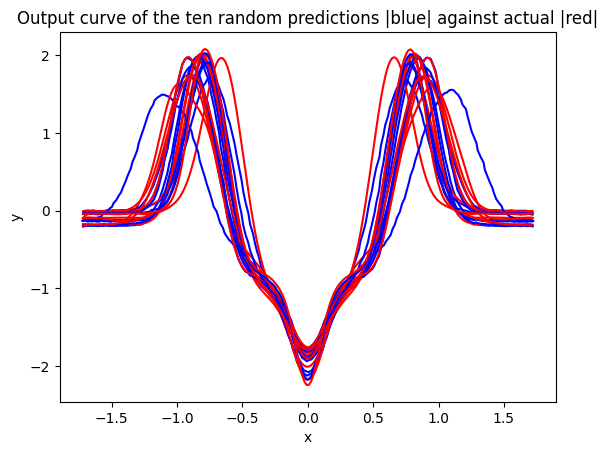

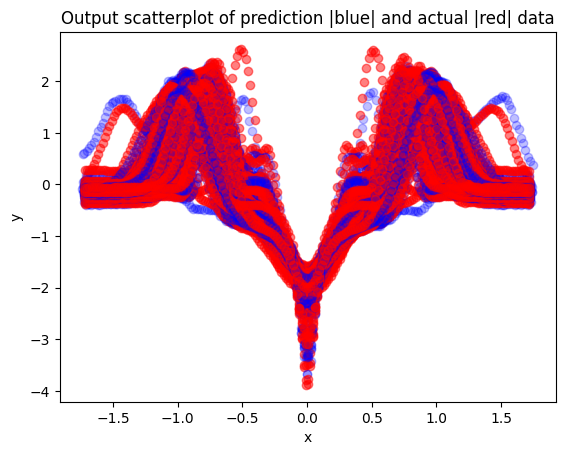

In [39]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=250),
             TensorBoard(log_dir='model_4_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))